In [ ]:
from google.colab import files
uploaded = files.upload()

Saving aligned_data_2018_2023_all_11202024.csv to aligned_data_2018_2023_all_11202024.csv


## **SMOTE** (Balances imbalanced datasets by creating Synthetic samples of the minority class)

In [ ]:
# Imports
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

df = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')
X = df.drop(columns=['flag3'])  # Replace 'flag3' if your target column name is different
y = df['flag3']

X = X.fillna(X.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [100],
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

rf = RandomForestClassifier(random_state=42, class_weight='balanced')
grid = GridSearchCV(rf, param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)
grid.fit(X_train_resampled, y_train_resampled)

best_rf = grid.best_estimator_

y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]


print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Confusion Matrix:
[[18782   478]
 [   86  5275]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     19260
           1       0.92      0.98      0.95      5361

    accuracy                           0.98     24621
   macro avg       0.96      0.98      0.97     24621
weighted avg       0.98      0.98      0.98     24621

ROC AUC Score: 0.9970


### **SMOTE and Early warning labels** (training to recognize precursor signals that precede the event, instead of learning to react to it in real-time.)

### 3 hour early warning labels (mark the occurance of event 3 hours before to predict earlier)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Confusion Matrix:
[[18555  2756]
 [  497  2813]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.87      0.92     21311
         1.0       0.51      0.85      0.63      3310

    accuracy                           0.87     24621
   macro avg       0.74      0.86      0.78     24621
weighted avg       0.91      0.87      0.88     24621

ROC AUC Score: 0.9295


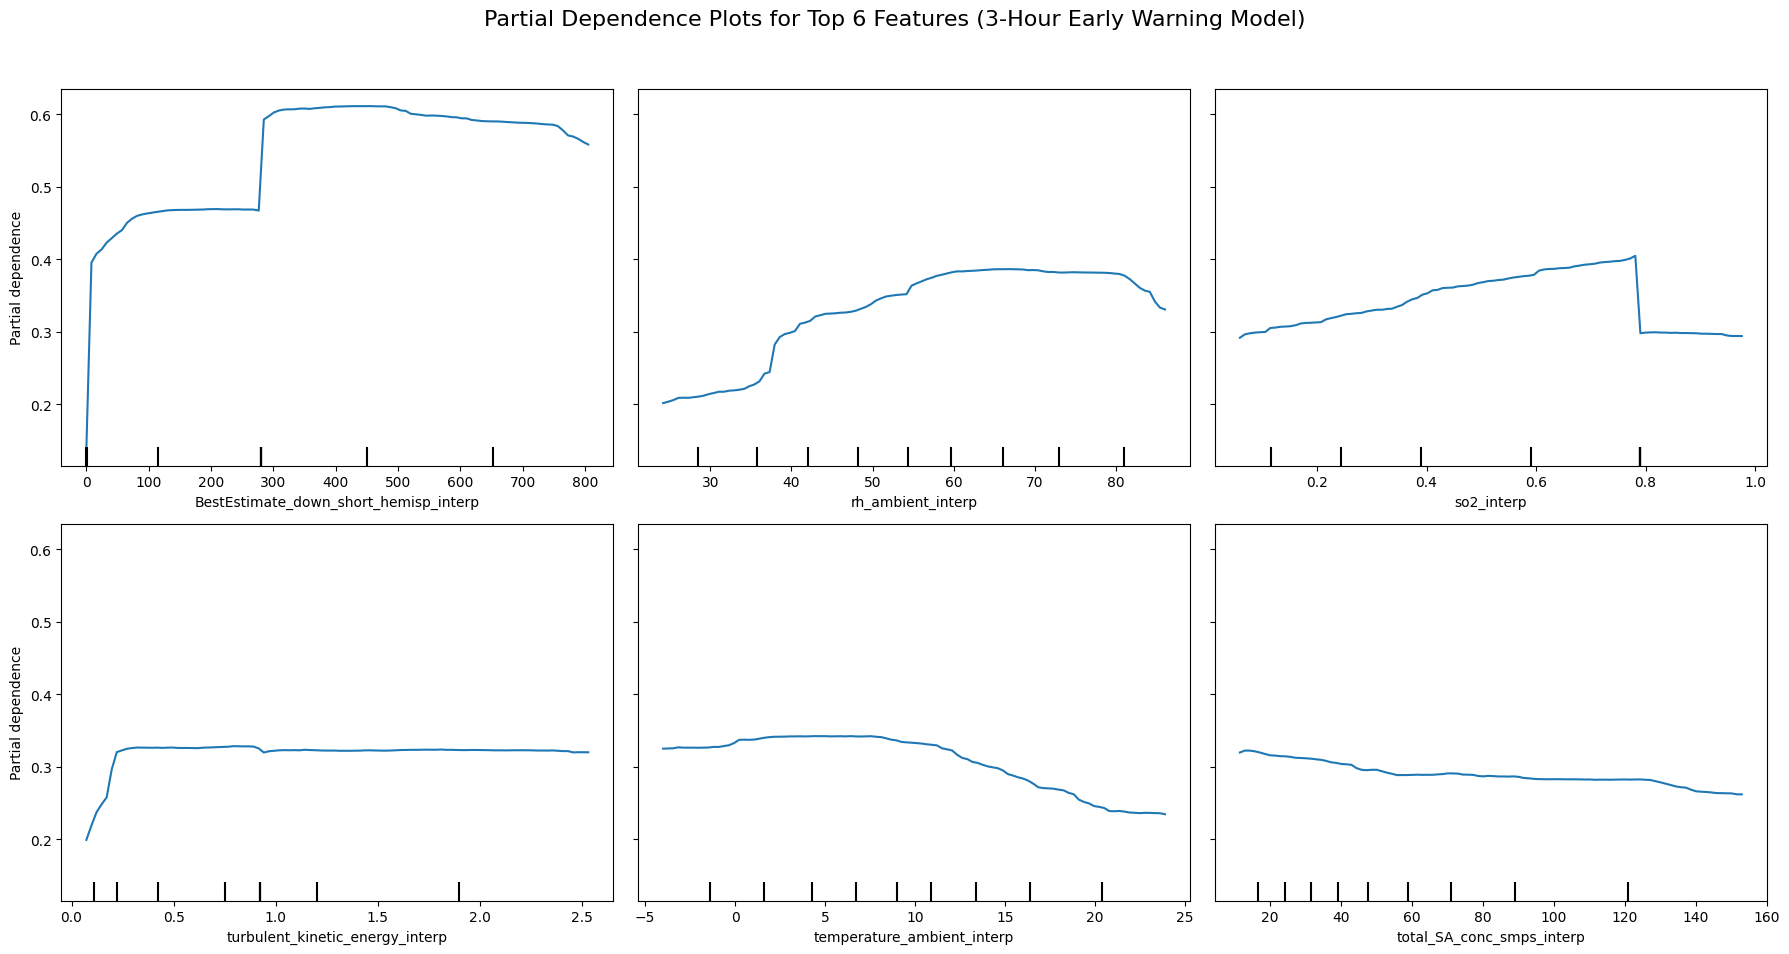

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import PartialDependenceDisplay
from imblearn.over_sampling import SMOTE

features_columns = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]

# Step 2: Helper function to mark 3-hour early warning labels
def mark_pre_npf_signal(df, flag_column='flag3', window=36):
    signal = np.zeros(len(df))
    for i in range(1, len(df)):
        if df[flag_column].iloc[i] == 1 and df[flag_column].iloc[i - 1] == 0:
            start = max(0, i - window)
            signal[start:i] = 1
    return pd.Series(signal, index=df.index, name='npf_signal')

df = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')
df['npf_signal'] = mark_pre_npf_signal(df, 'flag3', window=36)

#Prepare X and y (only 12 selected features)
X = df[features_columns].fillna(df[features_columns].mean())
y = df['npf_signal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [100],
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
grid = GridSearchCV(rf, param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)
grid.fit(X_train_resampled, y_train_resampled)

best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# Get feature importances
importances = best_rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# PDP for Top 6 Features
top6_features = importance_df['Feature'].head(6).tolist()
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
PartialDependenceDisplay.from_estimator(best_rf, X_train, top6_features, ax=ax)
plt.suptitle("Partial Dependence Plots for Top 6 Features (3-Hour Early Warning Model)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### 4 hour early warning labels (mark the occurance of event 4 hours before to predict earlier)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Confusion Matrix:
[[17316  2927]
 [  709  3669]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.86      0.90     20243
         1.0       0.56      0.84      0.67      4378

    accuracy                           0.85     24621
   macro avg       0.76      0.85      0.79     24621
weighted avg       0.89      0.85      0.86     24621

ROC AUC Score: 0.9159


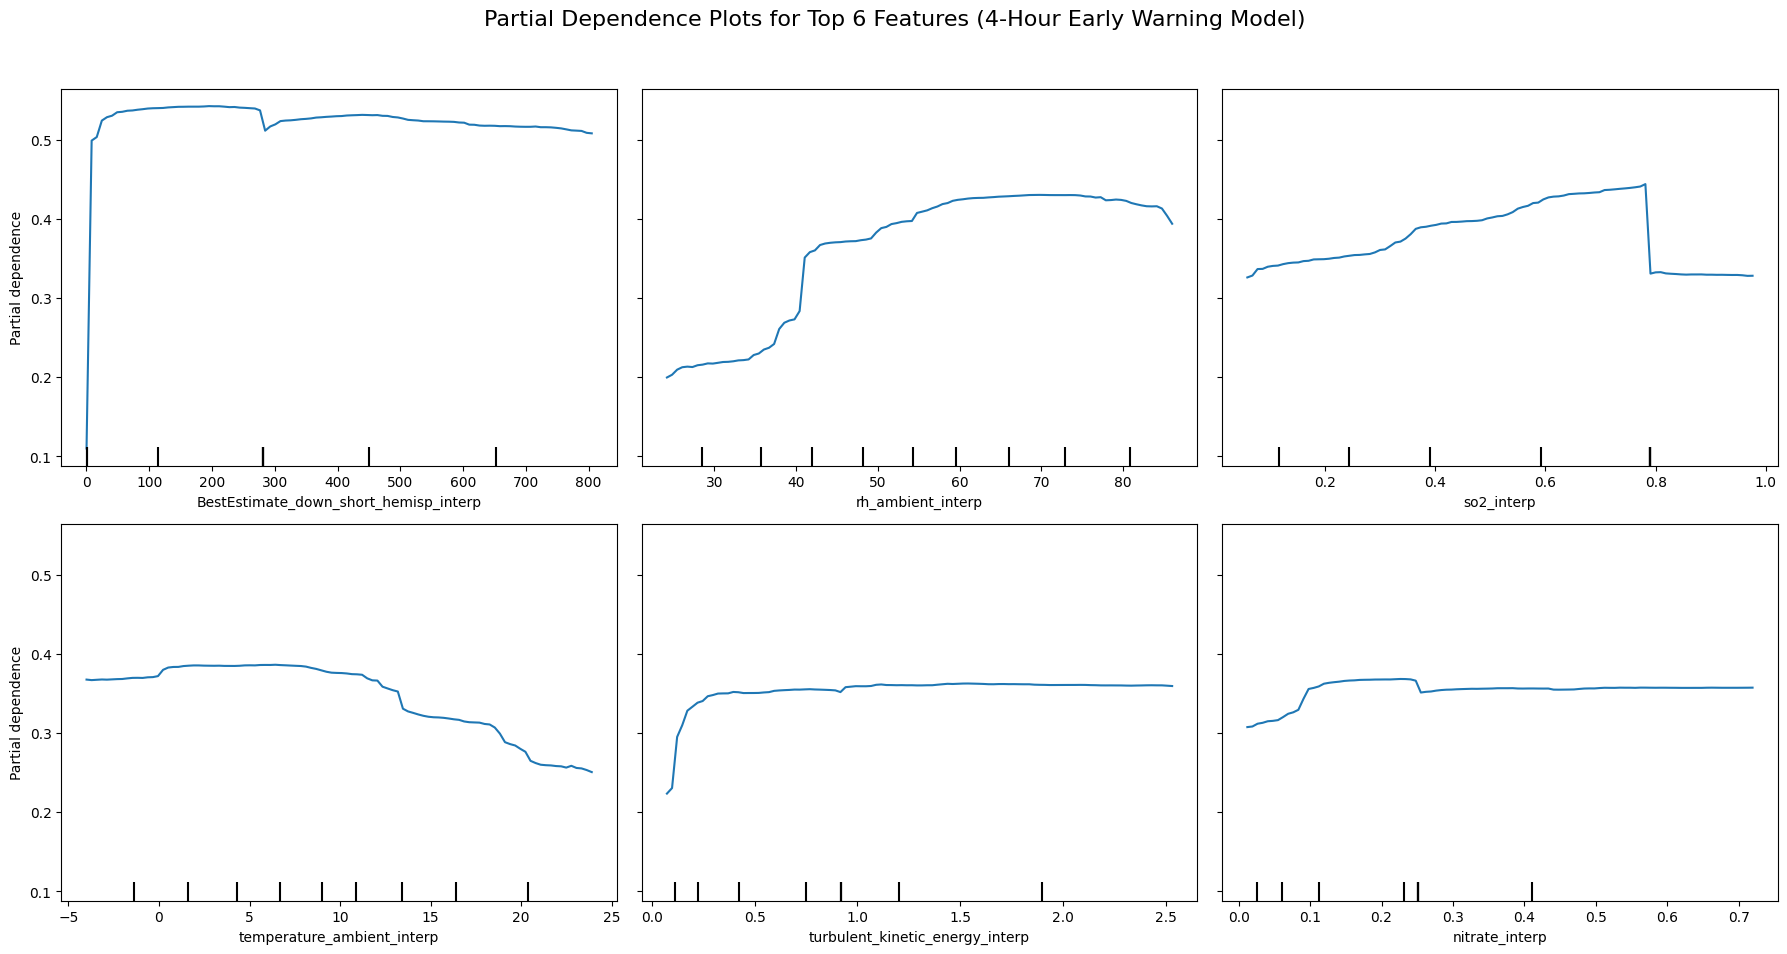

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import PartialDependenceDisplay
from imblearn.over_sampling import SMOTE

features_columns = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]

def mark_pre_npf_signal(df, flag_column='flag3', window=48):
    signal = np.zeros(len(df))
    for i in range(1, len(df)):
        if df[flag_column].iloc[i] == 1 and df[flag_column].iloc[i - 1] == 0:
            start = max(0, i - window)
            signal[start:i] = 1
    return pd.Series(signal, index=df.index, name='npf_signal')


df = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')

df['npf_signal'] = mark_pre_npf_signal(df, 'flag3', window=48)

X = df[features_columns].fillna(df[features_columns].mean())
y = df['npf_signal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [100],
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
grid = GridSearchCV(rf, param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)
grid.fit(X_train_resampled, y_train_resampled)

best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

importances = best_rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

top6_features = importance_df['Feature'].head(6).tolist()
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
PartialDependenceDisplay.from_estimator(best_rf, X_train, top6_features, ax=ax)
plt.suptitle("Partial Dependence Plots for Top 6 Features (4-Hour Early Warning Model)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### 6 hour early warning labels (mark the occurance of event 6 hours before to predict earlier)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Confusion Matrix:
[[14793  3276]
 [ 1306  5246]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.82      0.87     18069
         1.0       0.62      0.80      0.70      6552

    accuracy                           0.81     24621
   macro avg       0.77      0.81      0.78     24621
weighted avg       0.84      0.81      0.82     24621

ROC AUC Score: 0.9009


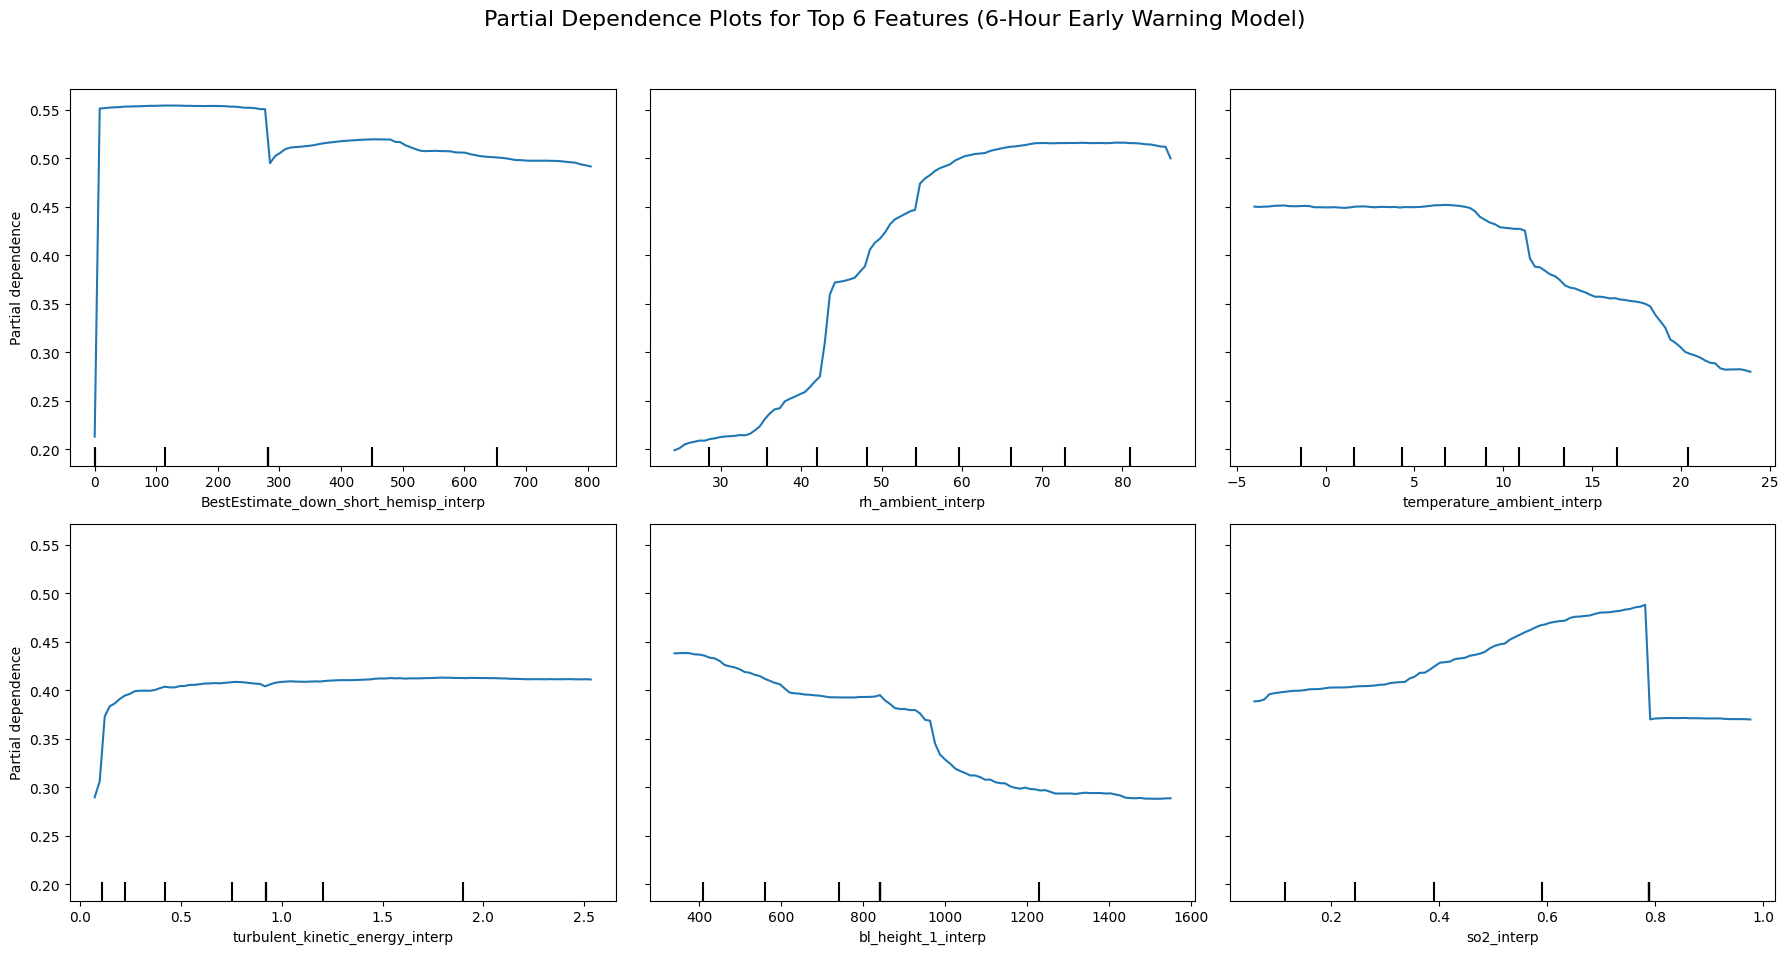

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import PartialDependenceDisplay
from imblearn.over_sampling import SMOTE

features_columns = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]

def mark_pre_npf_signal(df, flag_column='flag3', window=72):
    signal = np.zeros(len(df))
    for i in range(1, len(df)):
        if df[flag_column].iloc[i] == 1 and df[flag_column].iloc[i - 1] == 0:
            start = max(0, i - window)
            signal[start:i] = 1
    return pd.Series(signal, index=df.index, name='npf_signal')

df = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')
df['npf_signal'] = mark_pre_npf_signal(df, 'flag3', window=72)

X = df[features_columns].fillna(df[features_columns].mean())
y = df['npf_signal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [100],
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
grid = GridSearchCV(rf, param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)
grid.fit(X_train_resampled, y_train_resampled)

best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

importances = best_rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

top6_features = importance_df['Feature'].head(6).tolist()
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
PartialDependenceDisplay.from_estimator(best_rf, X_train, top6_features, ax=ax)
plt.suptitle("Partial Dependence Plots for Top 6 Features (6-Hour Early Warning Model)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### 8 hour early warning labels (mark the occurance of event 8 hours before to predict earlier)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Confusion Matrix:
[[12374  3603]
 [ 1280  7364]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.77      0.84     15977
         1.0       0.67      0.85      0.75      8644

    accuracy                           0.80     24621
   macro avg       0.79      0.81      0.79     24621
weighted avg       0.82      0.80      0.81     24621

ROC AUC Score: 0.9023


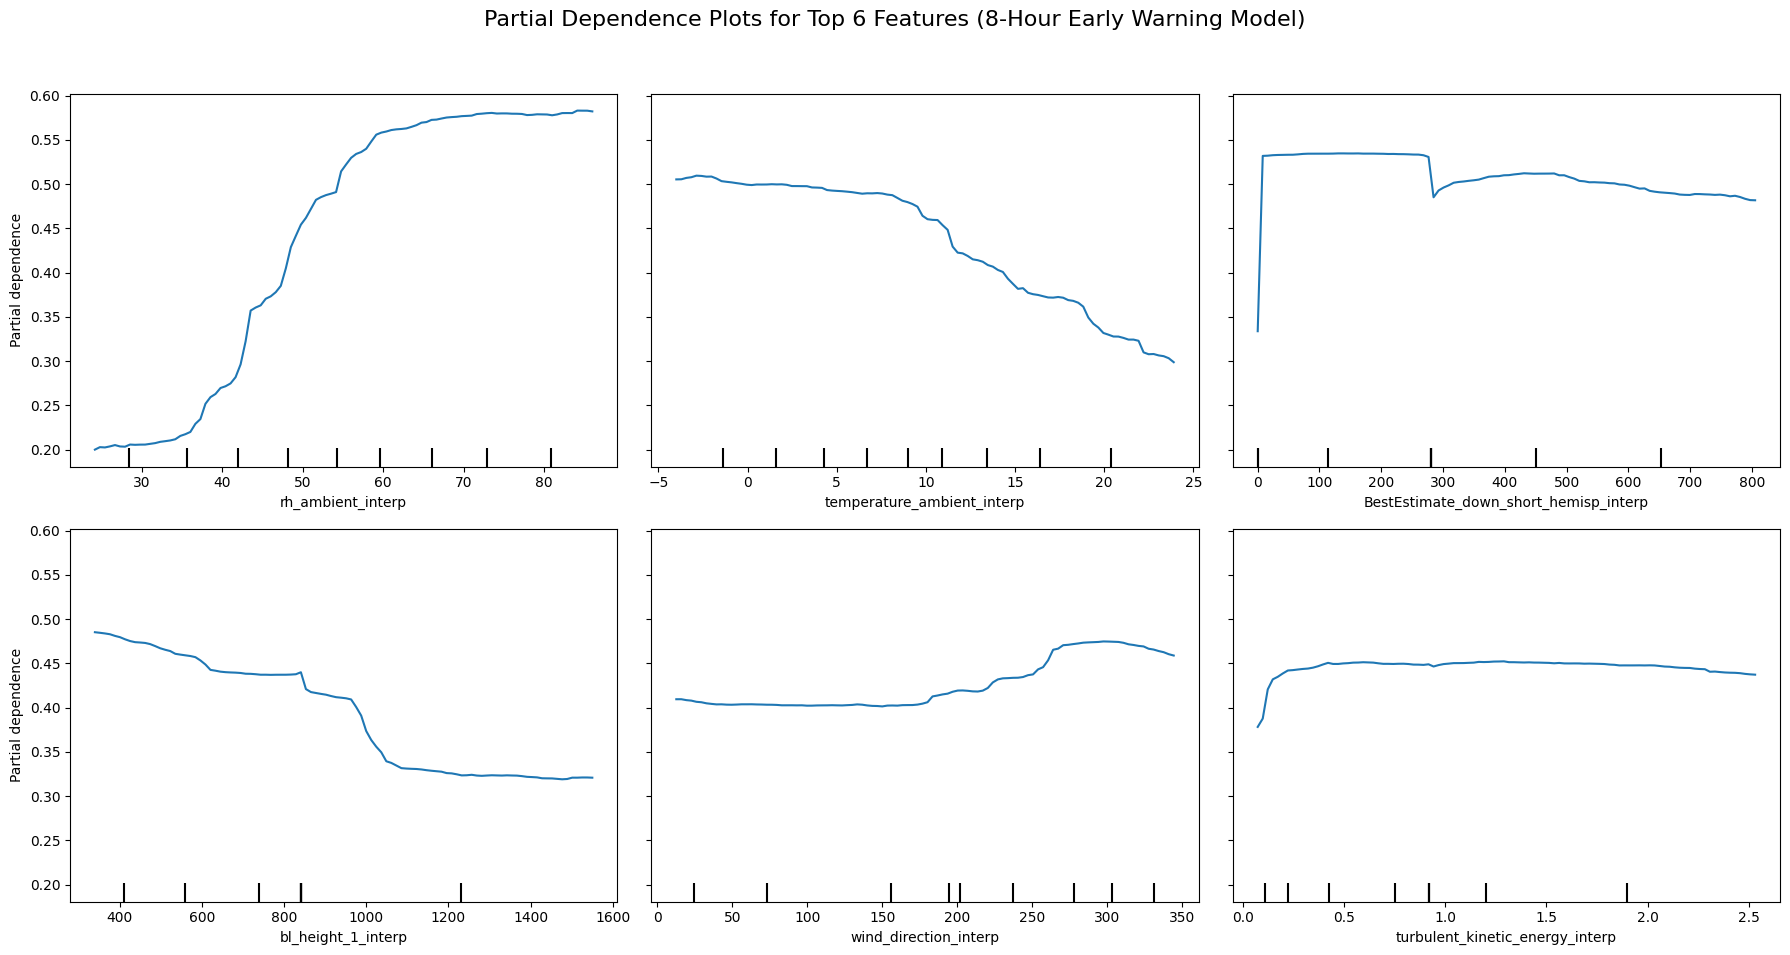

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import PartialDependenceDisplay
from imblearn.over_sampling import SMOTE

features_columns = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]

def mark_pre_npf_signal(df, flag_column='flag3', window=96):
    signal = np.zeros(len(df))
    for i in range(1, len(df)):
        if df[flag_column].iloc[i] == 1 and df[flag_column].iloc[i - 1] == 0:
            start = max(0, i - window)
            signal[start:i] = 1
    return pd.Series(signal, index=df.index, name='npf_signal')

df = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')
df['npf_signal'] = mark_pre_npf_signal(df, 'flag3', window=96)

X = df[features_columns].fillna(df[features_columns].mean())
y = df['npf_signal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [100],
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
grid = GridSearchCV(rf, param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)
grid.fit(X_train_resampled, y_train_resampled)

best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

importances = best_rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

top6_features = importance_df['Feature'].head(6).tolist()
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
PartialDependenceDisplay.from_estimator(best_rf, X_train, top6_features, ax=ax)
plt.suptitle("Partial Dependence Plots for Top 6 Features (8-Hour Early Warning Model)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 10 hour early warning labels (mark the occurance of event 10 hours before to predict earlier)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Confusion Matrix:
[[10589  3364]
 [ 1226  9442]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.76      0.82     13953
         1.0       0.74      0.89      0.80     10668

    accuracy                           0.81     24621
   macro avg       0.82      0.82      0.81     24621
weighted avg       0.83      0.81      0.81     24621

ROC AUC Score: 0.9146


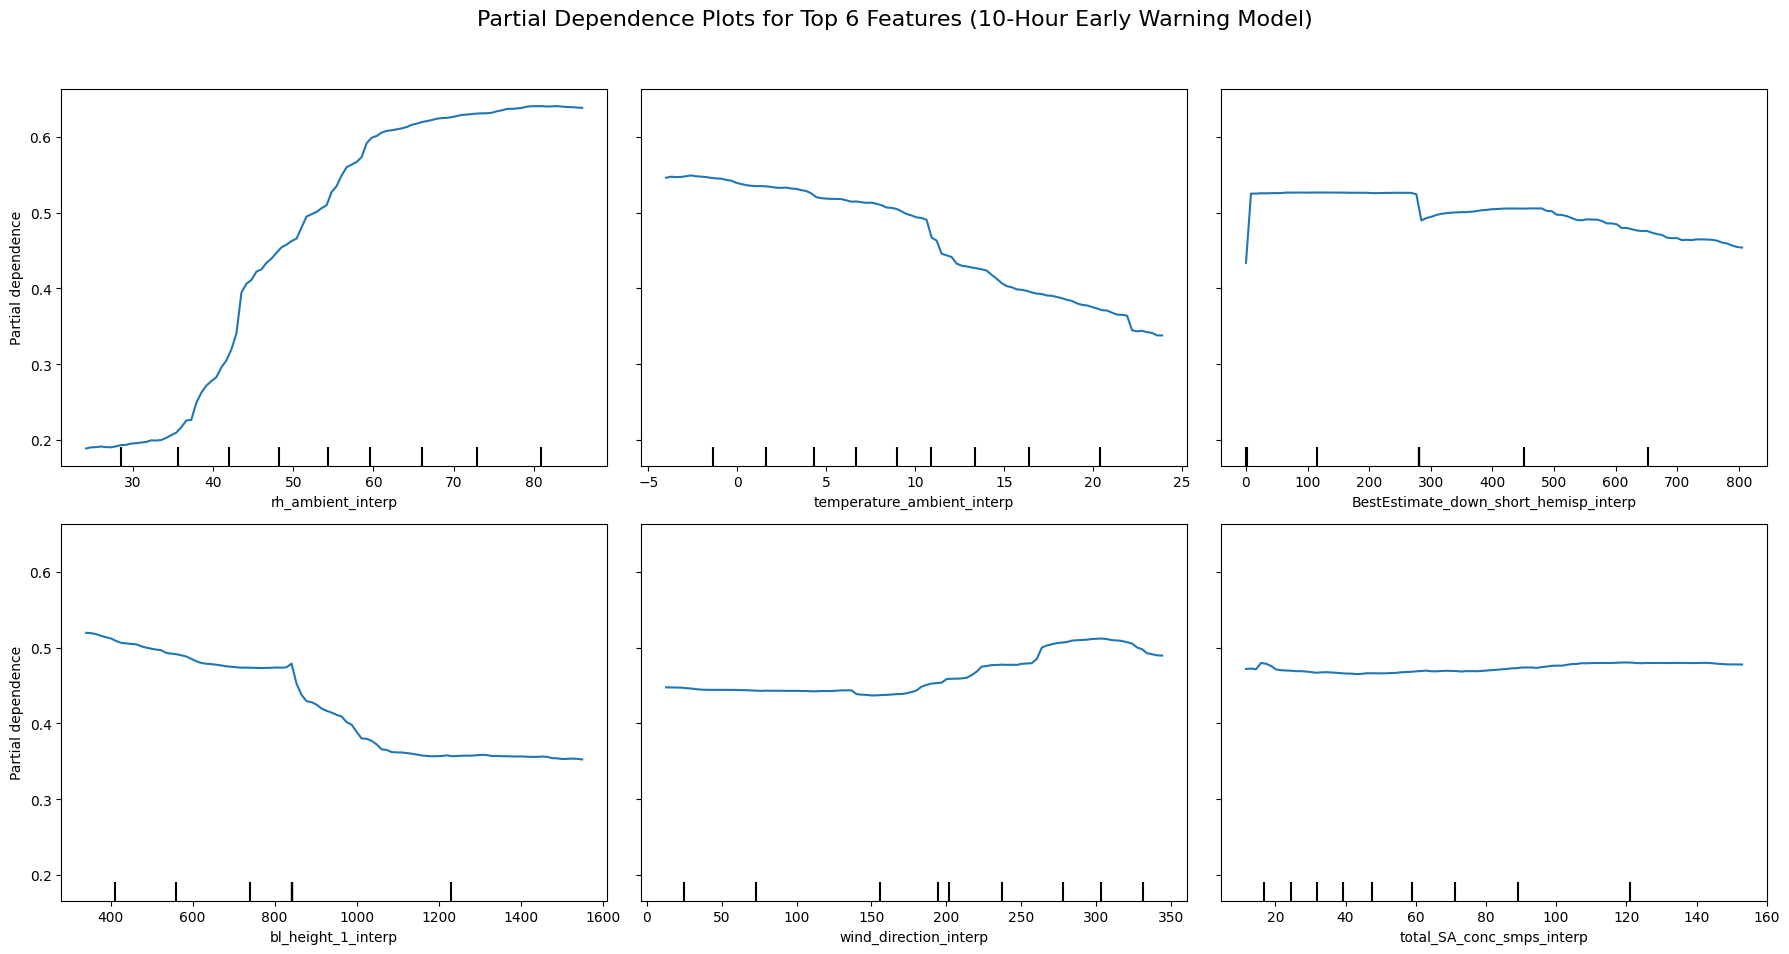

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import PartialDependenceDisplay
from imblearn.over_sampling import SMOTE

features_columns = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]

def mark_pre_npf_signal(df, flag_column='flag3', window=120):
    signal = np.zeros(len(df))
    for i in range(1, len(df)):
        if df[flag_column].iloc[i] == 1 and df[flag_column].iloc[i - 1] == 0:
            start = max(0, i - window)
            signal[start:i] = 1
    return pd.Series(signal, index=df.index, name='npf_signal')

df = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')
df['npf_signal'] = mark_pre_npf_signal(df, 'flag3', window=120)

X = df[features_columns].fillna(df[features_columns].mean())
y = df['npf_signal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [100],
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
grid = GridSearchCV(rf, param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)
grid.fit(X_train_resampled, y_train_resampled)

best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

importances = best_rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

top6_features = importance_df['Feature'].head(6).tolist()
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
PartialDependenceDisplay.from_estimator(best_rf, X_train, top6_features, ax=ax)
plt.suptitle("Partial Dependence Plots for Top 6 Features (10-Hour Early Warning Model)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 12 hour early warning labels (mark the occurance of event 12 hours before to predict earlier)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Confusion Matrix:
[[ 9393  2563]
 [ 1432 11233]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.79      0.82     11956
         1.0       0.81      0.89      0.85     12665

    accuracy                           0.84     24621
   macro avg       0.84      0.84      0.84     24621
weighted avg       0.84      0.84      0.84     24621

ROC AUC Score: 0.9246


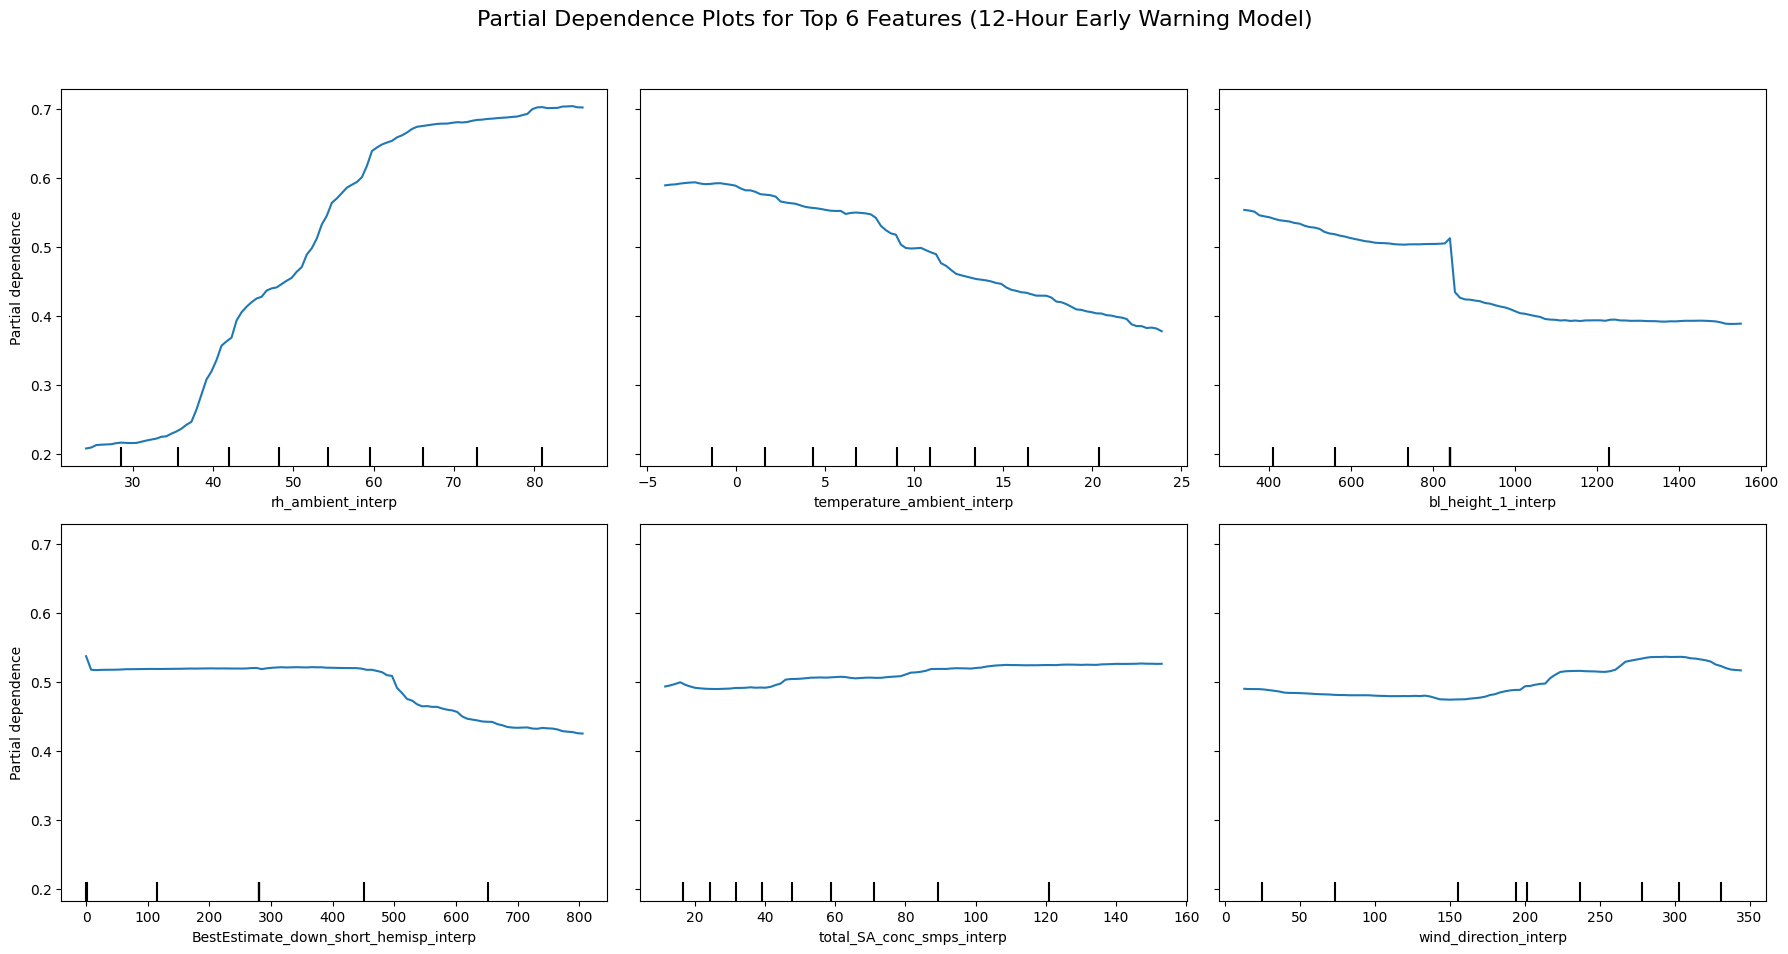

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import PartialDependenceDisplay
from imblearn.over_sampling import SMOTE

features_columns = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]

def mark_pre_npf_signal(df, flag_column='flag3', window=144):
    signal = np.zeros(len(df))
    for i in range(1, len(df)):
        if df[flag_column].iloc[i] == 1 and df[flag_column].iloc[i - 1] == 0:
            start = max(0, i - window)
            signal[start:i] = 1
    return pd.Series(signal, index=df.index, name='npf_signal')

df = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')
df['npf_signal'] = mark_pre_npf_signal(df, 'flag3', window=144)

X = df[features_columns].fillna(df[features_columns].mean())
y = df['npf_signal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [100],
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
grid = GridSearchCV(rf, param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)
grid.fit(X_train_resampled, y_train_resampled)

best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

importances = best_rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

top6_features = importance_df['Feature'].head(6).tolist()
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
PartialDependenceDisplay.from_estimator(best_rf, X_train, top6_features, ax=ax)
plt.suptitle("Partial Dependence Plots for Top 6 Features (12-Hour Early Warning Model)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## **XGboost**

These are tree-based like RF, but instead of averaging multiple trees (RF), GBMs build trees sequentially, each trying to correct the errors of the previous one.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

df = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')

def mark_pre_npf_signal(df, flag_column='flag3', window=36):
    signal = np.zeros(len(df))
    for i in range(1, len(df)):
        if df[flag_column].iloc[i] == 1 and df[flag_column].iloc[i - 1] == 0:
            start = max(0, i - window)
            signal[start:i] = 1
    return pd.Series(signal, index=df.index, name='npf_signal')

df['npf_signal'] = mark_pre_npf_signal(df, 'flag3', window=36)

features_columns = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]

X = df[features_columns].fillna(df[features_columns].mean())
y = df['npf_signal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
xgb.fit(X_train_resampled, y_train_resampled)

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:05:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
[[20063  1248]
 [  356  2954]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96     21311
         1.0       0.70      0.89      0.79      3310

    accuracy                           0.93     24621
   macro avg       0.84      0.92      0.87     24621
weighted avg       0.94      0.93      0.94     24621


ROC AUC Score: 0.9752


### 3 hour early warning labels (mark the occurance of event 3 hours before to predict earlier)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:16:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
[[20366   945]
 [  304  3006]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97     21311
         1.0       0.76      0.91      0.83      3310

    accuracy                           0.95     24621
   macro avg       0.87      0.93      0.90     24621
weighted avg       0.96      0.95      0.95     24621

ROC AUC Score: 0.9815


<ipython-input-2-1667820232>:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df, x='Importance', y='Feature', palette='viridis')


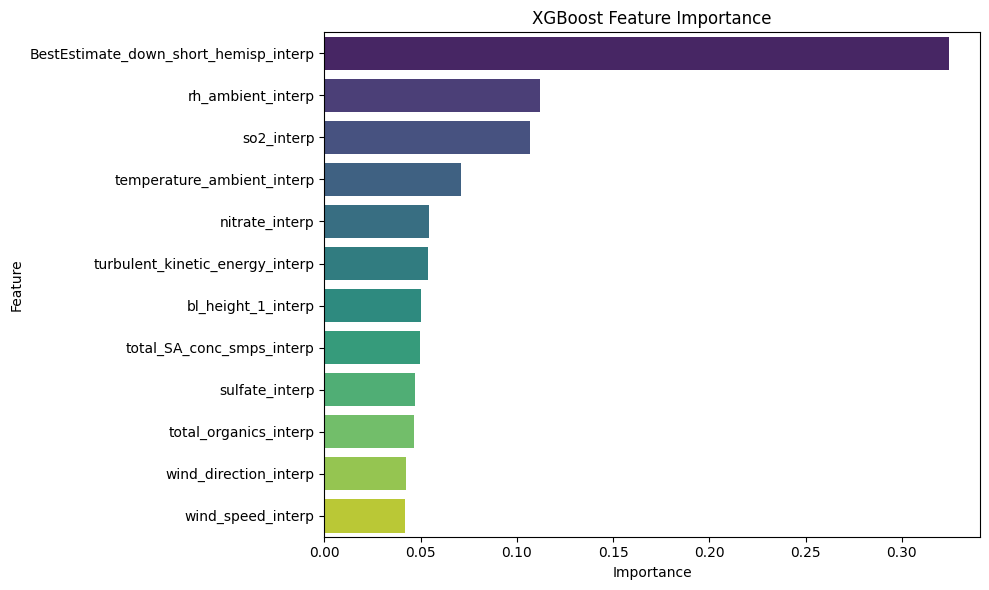

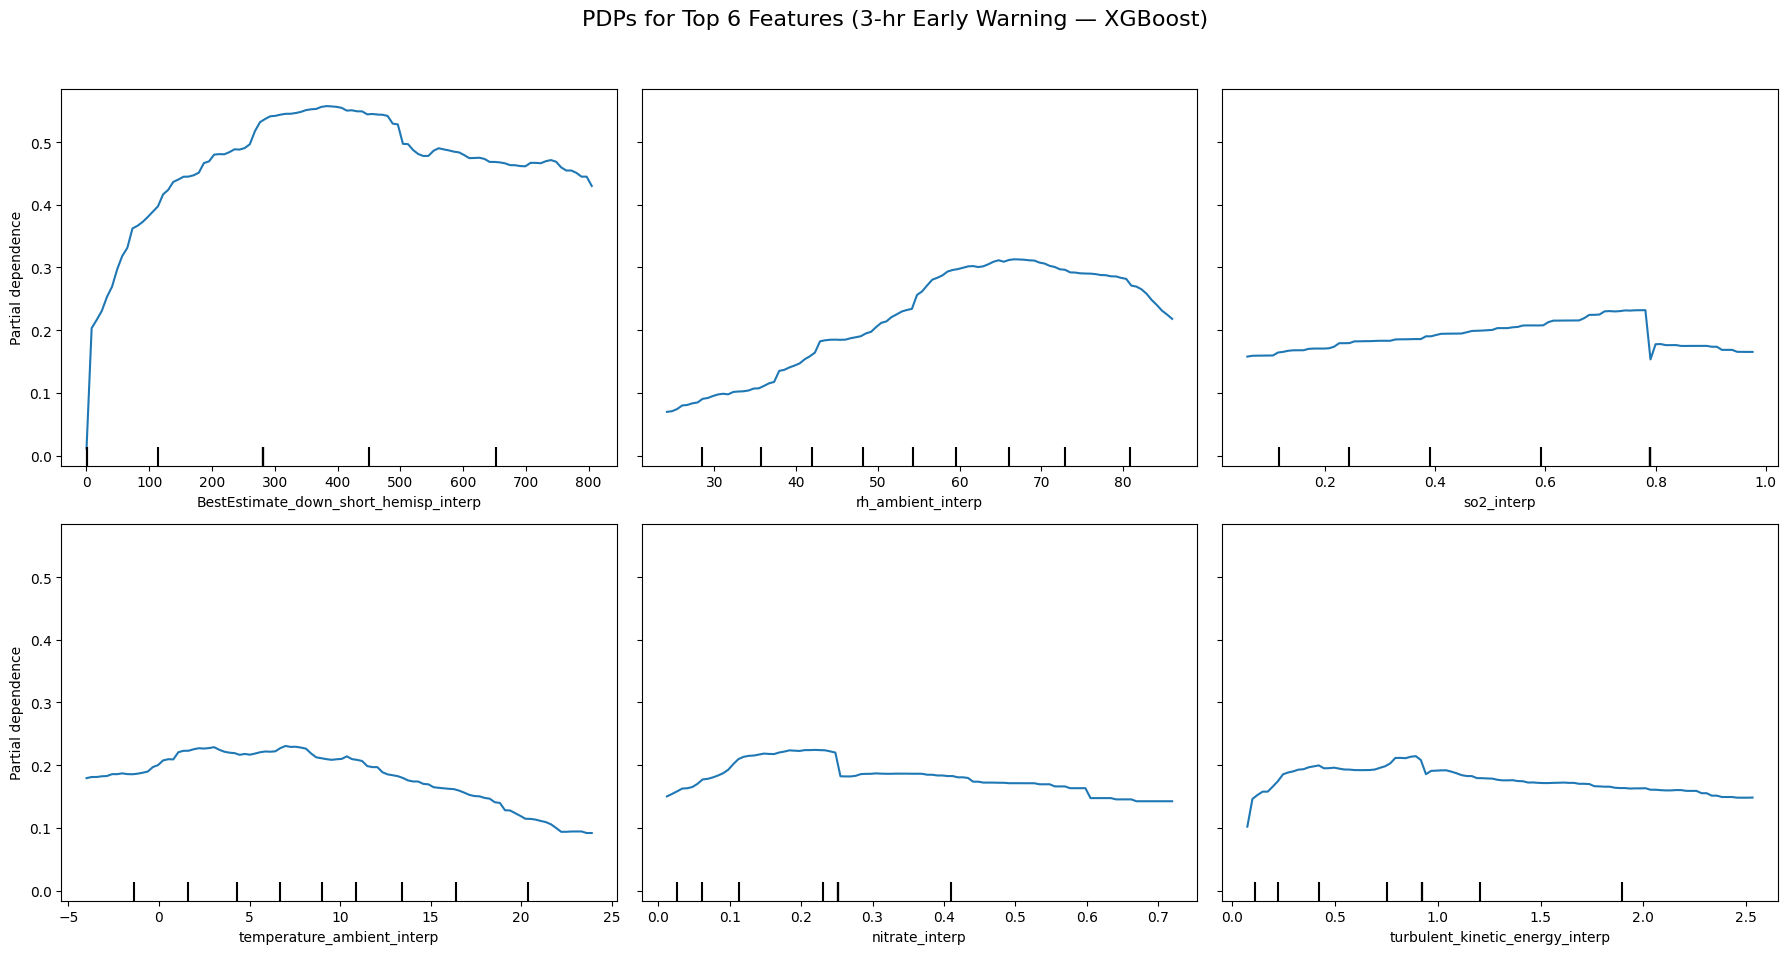

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import PartialDependenceDisplay
from imblearn.over_sampling import SMOTE

features_columns = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]

def mark_pre_npf_signal(df, flag_column='flag3', window=36):
    signal = np.zeros(len(df))
    for i in range(1, len(df)):
        if df[flag_column].iat[i] == 1 and df[flag_column].iat[i-1] == 0:
            start = max(0, i-window)
            signal[start:i] = 1
    return pd.Series(signal, index=df.index, name='npf_signal')

df = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')
df['npf_signal'] = mark_pre_npf_signal(df, 'flag3', window=36)

X = df[features_columns].fillna(df[features_columns].mean())
y = df['npf_signal']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
sm = SMOTE(random_state=42)
X_tr_res, y_tr_res = sm.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [100],
    'max_depth': [10],
    'learning_rate': [0.1],
    'subsample': [0.8]
}

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

grid = GridSearchCV(
    xgb, param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid.fit(X_tr_res, y_tr_res)

best_xgb = grid.best_estimator_

y_pred = best_xgb.predict(X_test)
y_prob = best_xgb.predict_proba(X_test)[:,1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

fi = best_xgb.feature_importances_
imp_df = pd.DataFrame({
    'Feature': features_columns,
    'Importance': fi
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=imp_df, x='Importance', y='Feature', palette='viridis')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

top6 = imp_df['Feature'].head(6).tolist()
fig, axes = plt.subplots(2,3, figsize=(18,10))
PartialDependenceDisplay.from_estimator(best_xgb, X_train, top6, ax=axes)
plt.suptitle("PDPs for Top 6 Features (3‑hr Early Warning — XGBoost)", fontsize=16)
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

### 4 hour early warning labels (mark the occurance of event 4 hours before to predict earlier)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:21:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
[[19377   866]
 [  472  3906]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97     20243
         1.0       0.82      0.89      0.85      4378

    accuracy                           0.95     24621
   macro avg       0.90      0.92      0.91     24621
weighted avg       0.95      0.95      0.95     24621

ROC AUC Score: 0.9788


<ipython-input-3-999830615>:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df, x='Importance', y='Feature', palette='viridis')


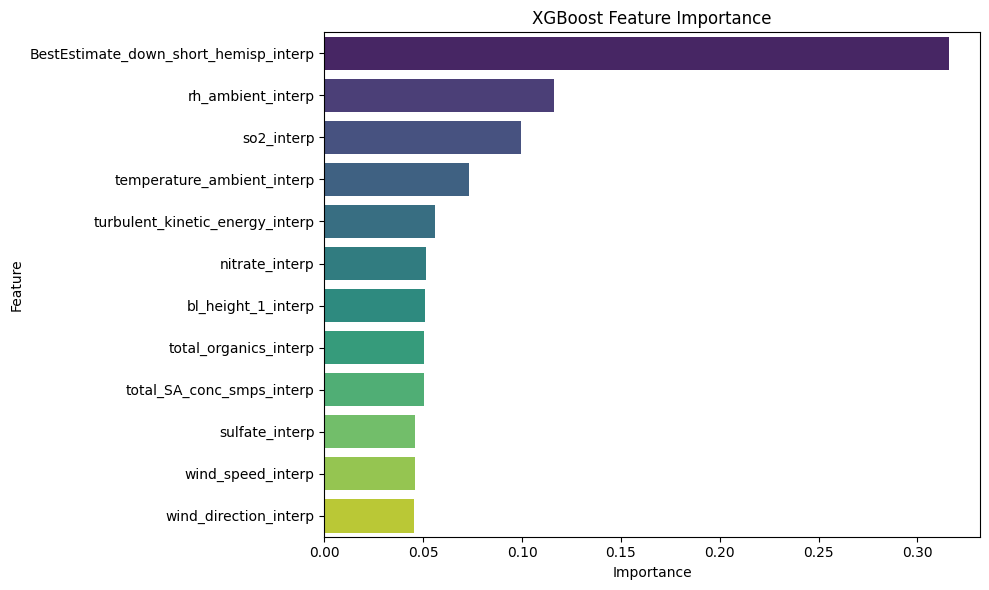

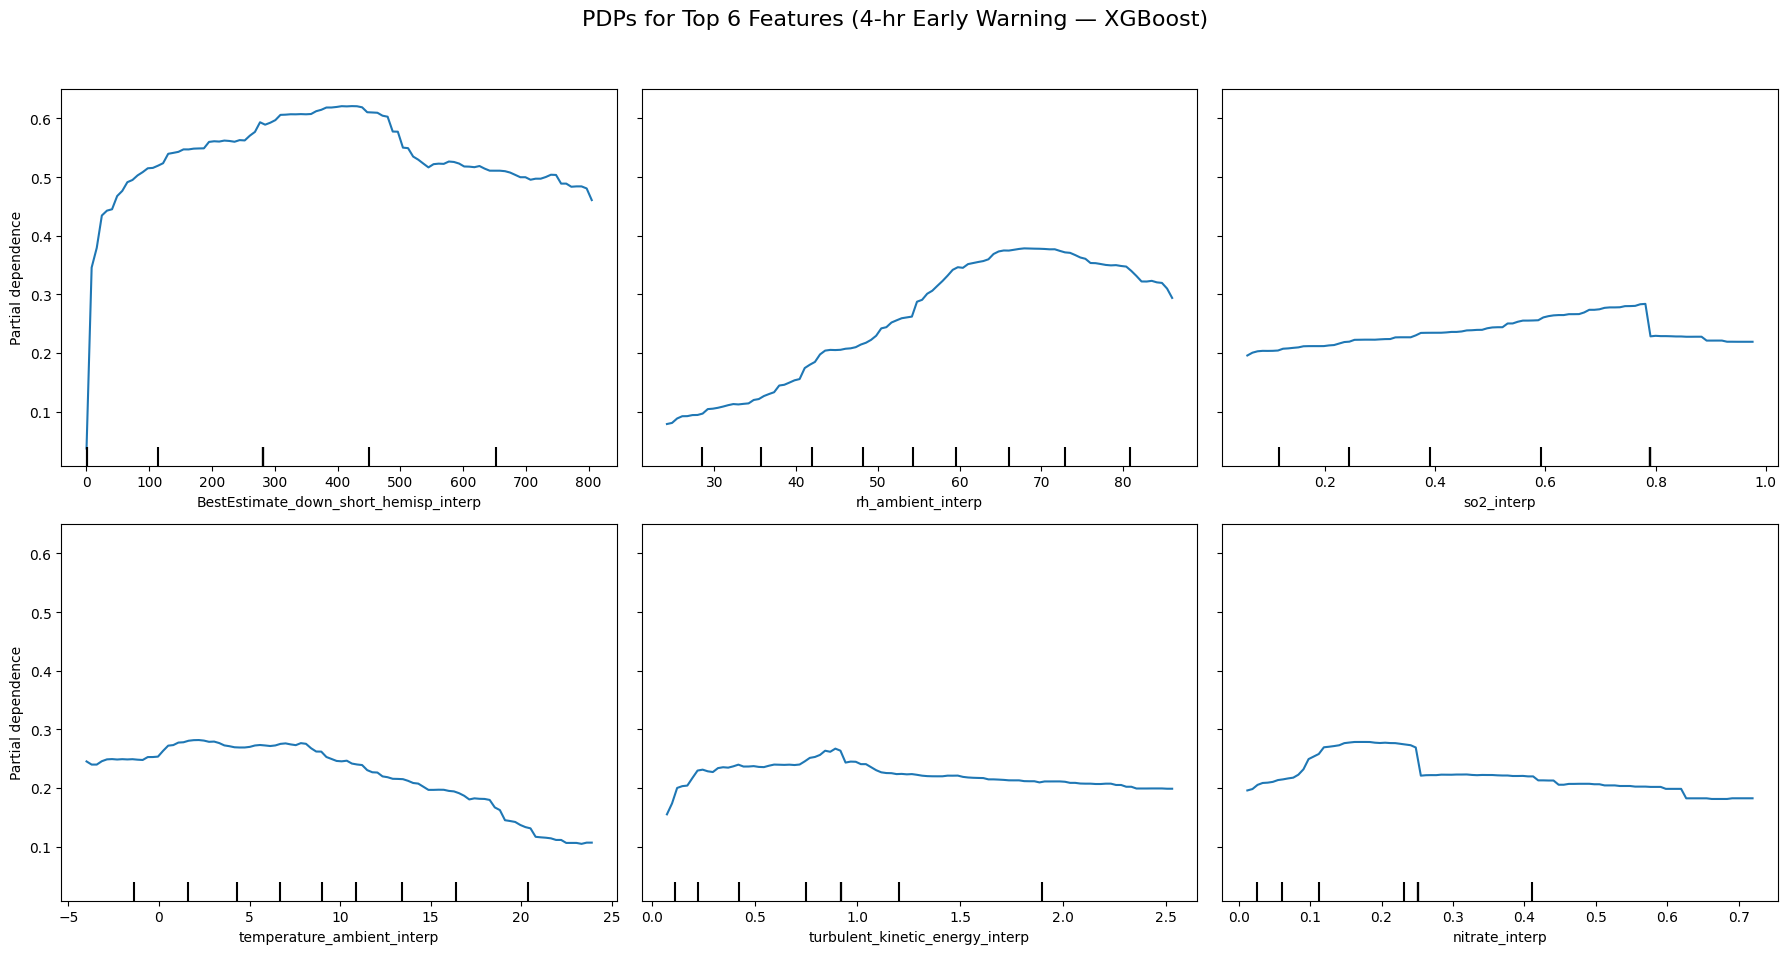

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import PartialDependenceDisplay
from imblearn.over_sampling import SMOTE

features_columns = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]

def mark_pre_npf_signal(df, flag_column='flag3', window=48):
    signal = np.zeros(len(df))
    for i in range(1, len(df)):
        if df[flag_column].iat[i] == 1 and df[flag_column].iat[i-1] == 0:
            start = max(0, i-window)
            signal[start:i] = 1
    return pd.Series(signal, index=df.index, name='npf_signal')

df = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')
df['npf_signal'] = mark_pre_npf_signal(df, 'flag3', window=48)

X = df[features_columns].fillna(df[features_columns].mean())
y = df['npf_signal']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
sm = SMOTE(random_state=42)
X_tr_res, y_tr_res = sm.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [100],
    'max_depth': [10],
    'learning_rate': [0.1],
    'subsample': [0.8]
}

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

grid = GridSearchCV(
    xgb, param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid.fit(X_tr_res, y_tr_res)

best_xgb = grid.best_estimator_

y_pred = best_xgb.predict(X_test)
y_prob = best_xgb.predict_proba(X_test)[:,1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

fi = best_xgb.feature_importances_
imp_df = pd.DataFrame({
    'Feature': features_columns,
    'Importance': fi
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=imp_df, x='Importance', y='Feature', palette='viridis')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

top6 = imp_df['Feature'].head(6).tolist()
fig, axes = plt.subplots(2,3, figsize=(18,10))
PartialDependenceDisplay.from_estimator(best_xgb, X_train, top6, ax=axes)
plt.suptitle("PDPs for Top 6 Features (4‑hr Early Warning — XGBoost)", fontsize=16)
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

### 6 hour early warning labels (mark the occurance of event 6 hours before to predict earlier)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:24:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
[[20366   945]
 [  304  3006]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97     21311
         1.0       0.76      0.91      0.83      3310

    accuracy                           0.95     24621
   macro avg       0.87      0.93      0.90     24621
weighted avg       0.96      0.95      0.95     24621

ROC AUC Score: 0.9815


<ipython-input-4-1727674597>:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df, x='Importance', y='Feature', palette='viridis')


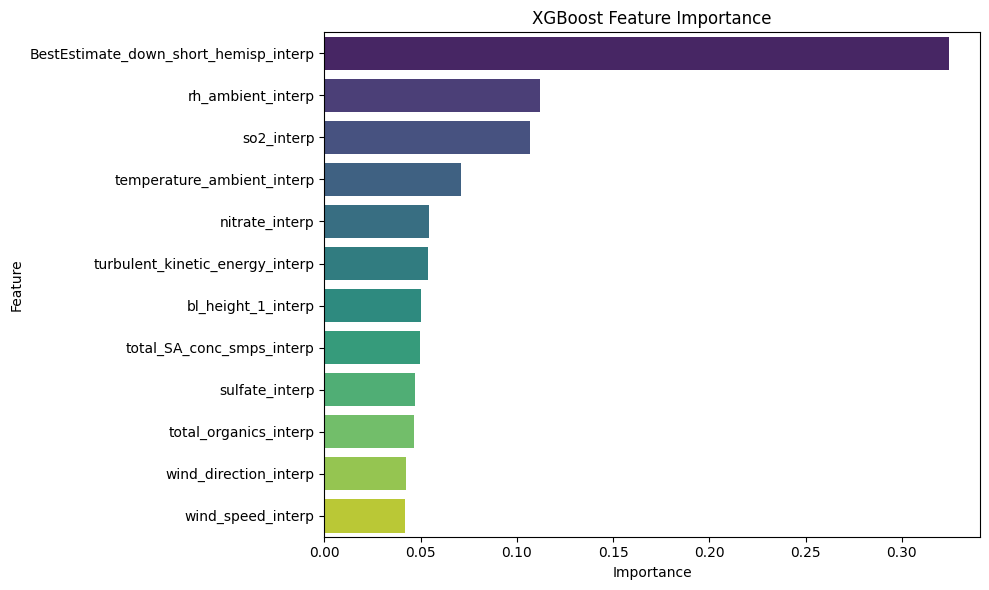

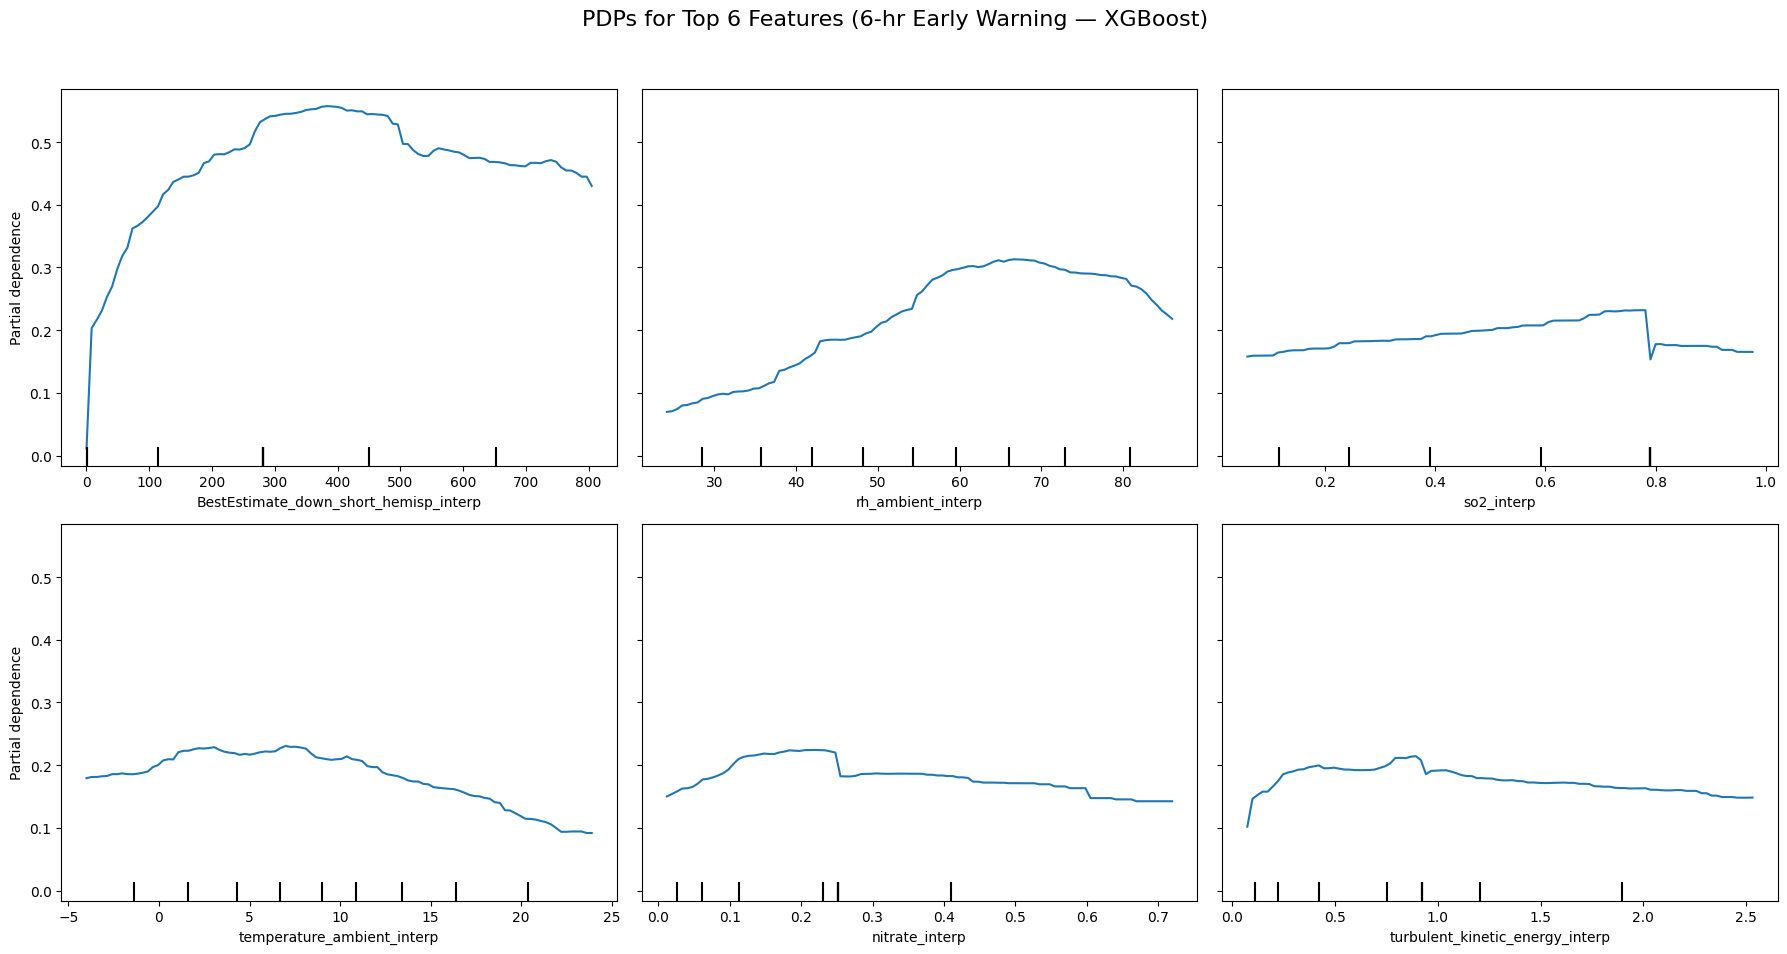

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import PartialDependenceDisplay
from imblearn.over_sampling import SMOTE

features_columns = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]

def mark_pre_npf_signal(df, flag_column='flag3', window=36):
    signal = np.zeros(len(df))
    for i in range(1, len(df)):
        if df[flag_column].iat[i] == 1 and df[flag_column].iat[i-1] == 0:
            start = max(0, i-window)
            signal[start:i] = 1
    return pd.Series(signal, index=df.index, name='npf_signal')

df = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')
df['npf_signal'] = mark_pre_npf_signal(df, 'flag3', window=36)

X = df[features_columns].fillna(df[features_columns].mean())
y = df['npf_signal']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
sm = SMOTE(random_state=42)
X_tr_res, y_tr_res = sm.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [100],
    'max_depth': [10],
    'learning_rate': [0.1],
    'subsample': [0.8]
}

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

grid = GridSearchCV(
    xgb, param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid.fit(X_tr_res, y_tr_res)

best_xgb = grid.best_estimator_

y_pred = best_xgb.predict(X_test)
y_prob = best_xgb.predict_proba(X_test)[:,1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

fi = best_xgb.feature_importances_
imp_df = pd.DataFrame({
    'Feature': features_columns,
    'Importance': fi
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=imp_df, x='Importance', y='Feature', palette='viridis')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

top6 = imp_df['Feature'].head(6).tolist()
fig, axes = plt.subplots(2,3, figsize=(18,10))
PartialDependenceDisplay.from_estimator(best_xgb, X_train, top6, ax=axes)
plt.suptitle("PDPs for Top 6 Features (6‑hr Early Warning — XGBoost)", fontsize=16)
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()


## **WORK**

In [ ]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score
from imblearn.over_sampling import SMOTE


def mark_pre_npf_signal(df, flag_column='flag3', window=36):
    signal = np.zeros(len(df))
    for i in range(1, len(df)):
        if df[flag_column].iat[i] == 1 and df[flag_column].iat[i-1] == 0:
            start = max(0, i-window)
            signal[start:i] = 1
    return pd.Series(signal, index=df.index, name='npf_signal')


# Load & label
df = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')
df['npf_signal'] = mark_pre_npf_signal(df, window=36)
features = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]
X = df[features].fillna(df[features].mean())
y = df['npf_signal']

# Train/test split & SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_tr, y_tr = SMOTE(random_state=42).fit_resample(X_train, y_train)

# Define models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

models = {
    'RF': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGB': XGBClassifier(max_depth=6, learning_rate=0.1, n_estimators=100,
                         eval_metric='logloss', use_label_encoder=False, random_state=42),
    'LGBM': LGBMClassifier(max_depth=6, learning_rate=0.1, n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(50,50), max_iter=200, random_state=42)
}

# Run and time each
results = []
all_predictions = {}

for name, model in models.items():
    t0 = time.time()
    model.fit(X_tr, y_tr)
    train_time = time.time() - t0

    t1 = time.time()
    preds = model.predict(X_test)
    infer_time = time.time() - t1

    probs = model.predict_proba(X_test)[:,1]
    all_predictions[name] = {'model': model, 'preds': preds, 'probs': probs}

    results.append({
        'Model': name,
        'F1': f1_score(y_test, preds),
        'Recall': recall_score(y_test, preds),
        'Precision': precision_score(y_test, preds),
        'AUC': roc_auc_score(y_test, probs),
        'TrainTime': train_time,
        'InferTime': infer_time,
        'Hyperparams': len(model.get_params()),
        'HasFeatureImp': hasattr(model, 'feature_importances_')
    })

df_res = pd.DataFrame(results)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:48:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 49993, number of negative: 49993
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 99986, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


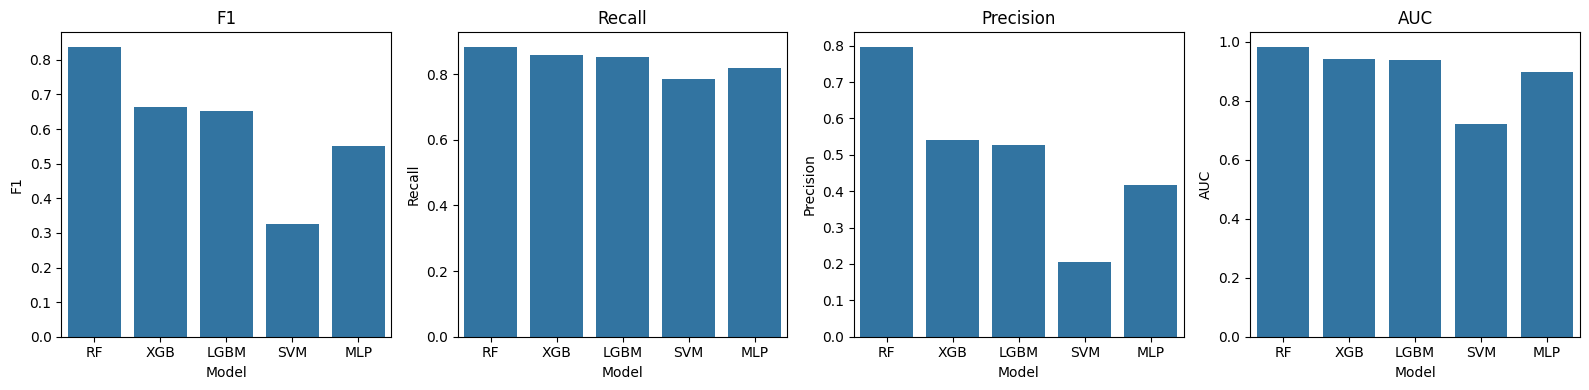

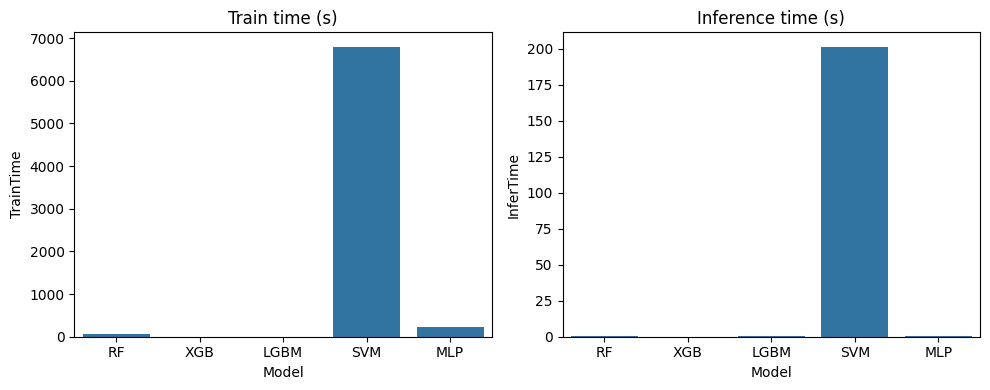

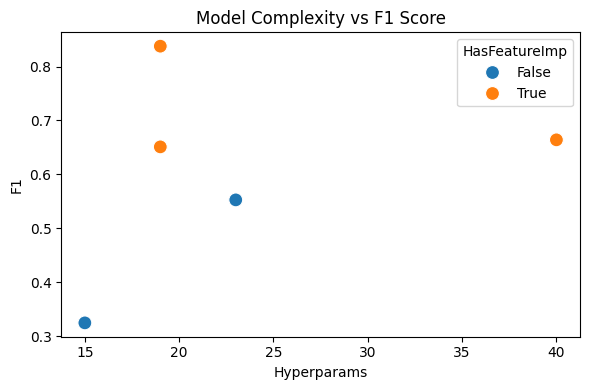

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bar plot for performance metrics
metrics = ['F1','Recall','Precision','AUC']
fig, axes = plt.subplots(1, len(metrics), figsize=(16,4))
for ax, m in zip(axes, metrics):
    sns.barplot(data=df_res, x='Model', y=m, ax=ax)
    ax.set_title(m)
plt.tight_layout()
plt.show()

# Training & inference time
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.barplot(data=df_res, x='Model', y='TrainTime', ax=ax[0]).set_title('Train time (s)')
sns.barplot(data=df_res, x='Model', y='InferTime', ax=ax[1]).set_title('Inference time (s)')
plt.tight_layout()
plt.show()

# Hyperparameter count vs interpretability
fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(data=df_res, x='Hyperparams', y='F1', hue='HasFeatureImp', s=100, ax=ax)
ax.set_title('Model Complexity vs F1 Score')
plt.tight_layout()
plt.show()

In [ ]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, recall_score, precision_score, roc_auc_score,
    confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE

# Helper to mark early NPF signals
def mark_pre_npf_signal(df, flag_column='flag3', window=36):
    signal = np.zeros(len(df))
    for i in range(1, len(df)):
        if df[flag_column].iat[i] == 1 and df[flag_column].iat[i-1] == 0:
            start = max(0, i - window)
            signal[start:i] = 1
    return pd.Series(signal, index=df.index, name='npf_signal')

# Load data
df = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')
df['npf_signal'] = mark_pre_npf_signal(df, window=36)

# Features and target
features = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]
X = df[features].fillna(df[features].mean())
y = df['npf_signal']

# Train-test split and SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_tr, y_tr = SMOTE(random_state=42).fit_resample(X_train, y_train)

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

models = {
    'RF': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGB': XGBClassifier(max_depth=6, learning_rate=0.1, n_estimators=100,
                         eval_metric='logloss', use_label_encoder=False, random_state=42),
    'LGBM': LGBMClassifier(max_depth=6, learning_rate=0.1, n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, C=1.0, gamma='scale', max_iter=1000, random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, random_state=42)
}

results = []
all_predictions = {}

for name, model in models.items():
    print(f"Training {name}...")

    t0 = time.time()
    model.fit(X_tr, y_tr)
    train_time = time.time() - t0

    t1 = time.time()
    preds = model.predict(X_test)
    infer_time = time.time() - t1

    probs = model.predict_proba(X_test)[:, 1]
    cm = confusion_matrix(y_test, preds)
    cr = classification_report(y_test, preds, digits=4, output_dict=True)

    all_predictions[name] = {
        'model': model,
        'preds': preds,
        'probs': probs,
        'conf_matrix': cm,
        'class_report': cr
    }

    results.append({
        'Model': name,
        'F1': f1_score(y_test, preds),
        'Recall': recall_score(y_test, preds),
        'Precision': precision_score(y_test, preds),
        'AUC': roc_auc_score(y_test, probs),
        'TrainTime': train_time,
        'InferTime': infer_time,
        'Hyperparams': len(model.get_params()),
        'HasFeatureImp': hasattr(model, 'feature_importances_')
    })

df_res = pd.DataFrame(results)


Training RF...
Training XGB...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:53:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training LGBM...
[LightGBM] [Info] Number of positive: 49993, number of negative: 49993
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 99986, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training MLP...



Confusion Matrix - RF
[[20567   744]
 [  388  2922]]


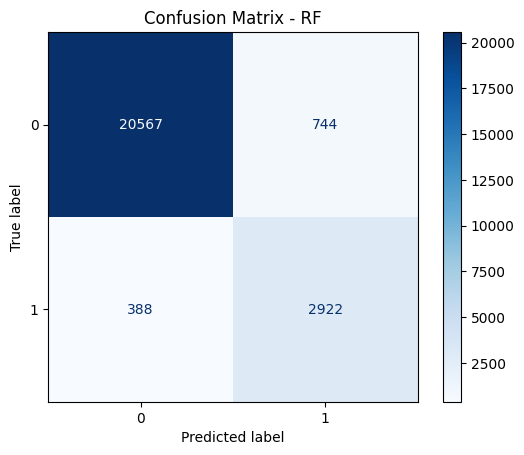

Classification Report - RF
              precision    recall  f1-score       support
0.0            0.981484  0.965088  0.973217  21311.000000
1.0            0.797054  0.882779  0.837729   3310.000000
accuracy       0.954023  0.954023  0.954023      0.954023
macro avg      0.889269  0.923934  0.905473  24621.000000
weighted avg   0.956690  0.954023  0.955003  24621.000000

Confusion Matrix - XGB
[[18900  2411]
 [  467  2843]]


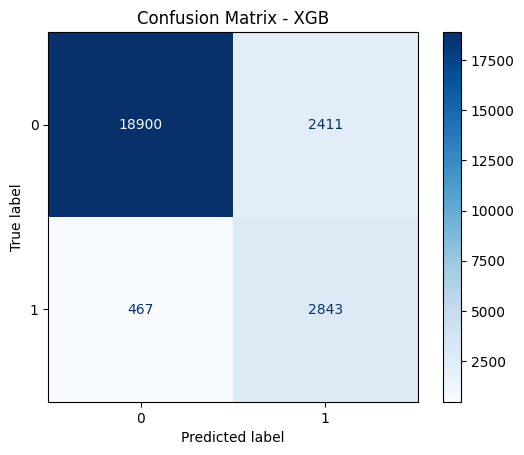

Classification Report - XGB
              precision    recall  f1-score       support
0.0            0.975887  0.886866  0.929249  21311.000000
1.0            0.541112  0.858912  0.663942   3310.000000
accuracy       0.883108  0.883108  0.883108      0.883108
macro avg      0.758499  0.872889  0.796596  24621.000000
weighted avg   0.917436  0.883108  0.893582  24621.000000

Confusion Matrix - LGBM
[[18774  2537]
 [  489  2821]]


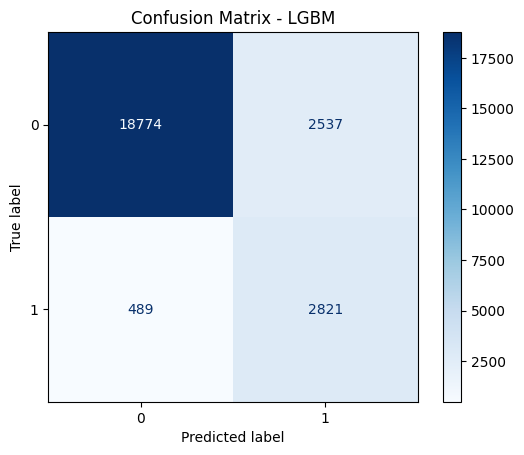

Classification Report - LGBM
              precision    recall  f1-score       support
0.0            0.974615  0.880953  0.925420  21311.000000
1.0            0.526502  0.852266  0.650900   3310.000000
accuracy       0.877097  0.877097  0.877097      0.877097
macro avg      0.750558  0.866610  0.788160  24621.000000
weighted avg   0.914371  0.877097  0.888514  24621.000000

Confusion Matrix - SVM
[[ 1402 19909]
 [   83  3227]]


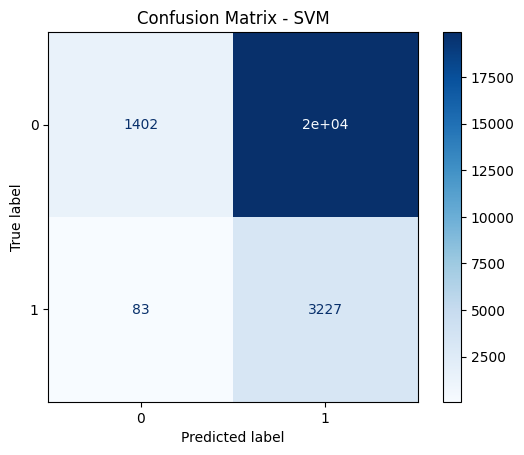

Classification Report - SVM
              precision    recall  f1-score      support
0.0            0.944108  0.065788  0.123004  21311.00000
1.0            0.139480  0.974924  0.244044   3310.00000
accuracy       0.188010  0.188010  0.188010      0.18801
macro avg      0.541794  0.520356  0.183524  24621.00000
weighted avg   0.835935  0.188010  0.139276  24621.00000

Confusion Matrix - MLP
[[17809  3502]
 [  940  2370]]


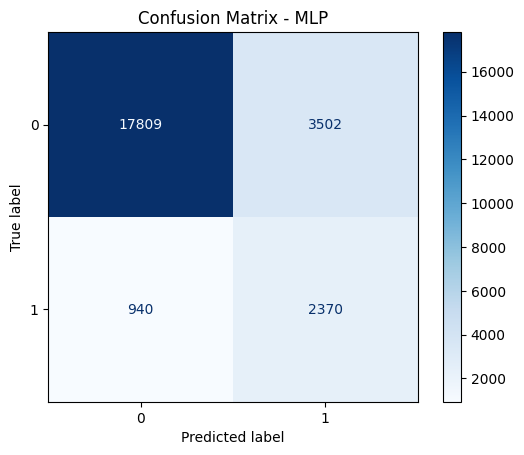

Classification Report - MLP
              precision    recall  f1-score       support
0.0            0.949864  0.835672  0.889116  21311.000000
1.0            0.403610  0.716012  0.516227   3310.000000
accuracy       0.819585  0.819585  0.819585      0.819585
macro avg      0.676737  0.775842  0.702672  24621.000000
weighted avg   0.876427  0.819585  0.838986  24621.000000


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for model_name, items in all_predictions.items():
    cm = items['conf_matrix']
    print(f"\nConfusion Matrix - {model_name}")
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    print(f"Classification Report - {model_name}")
    print(pd.DataFrame(items['class_report']).T)

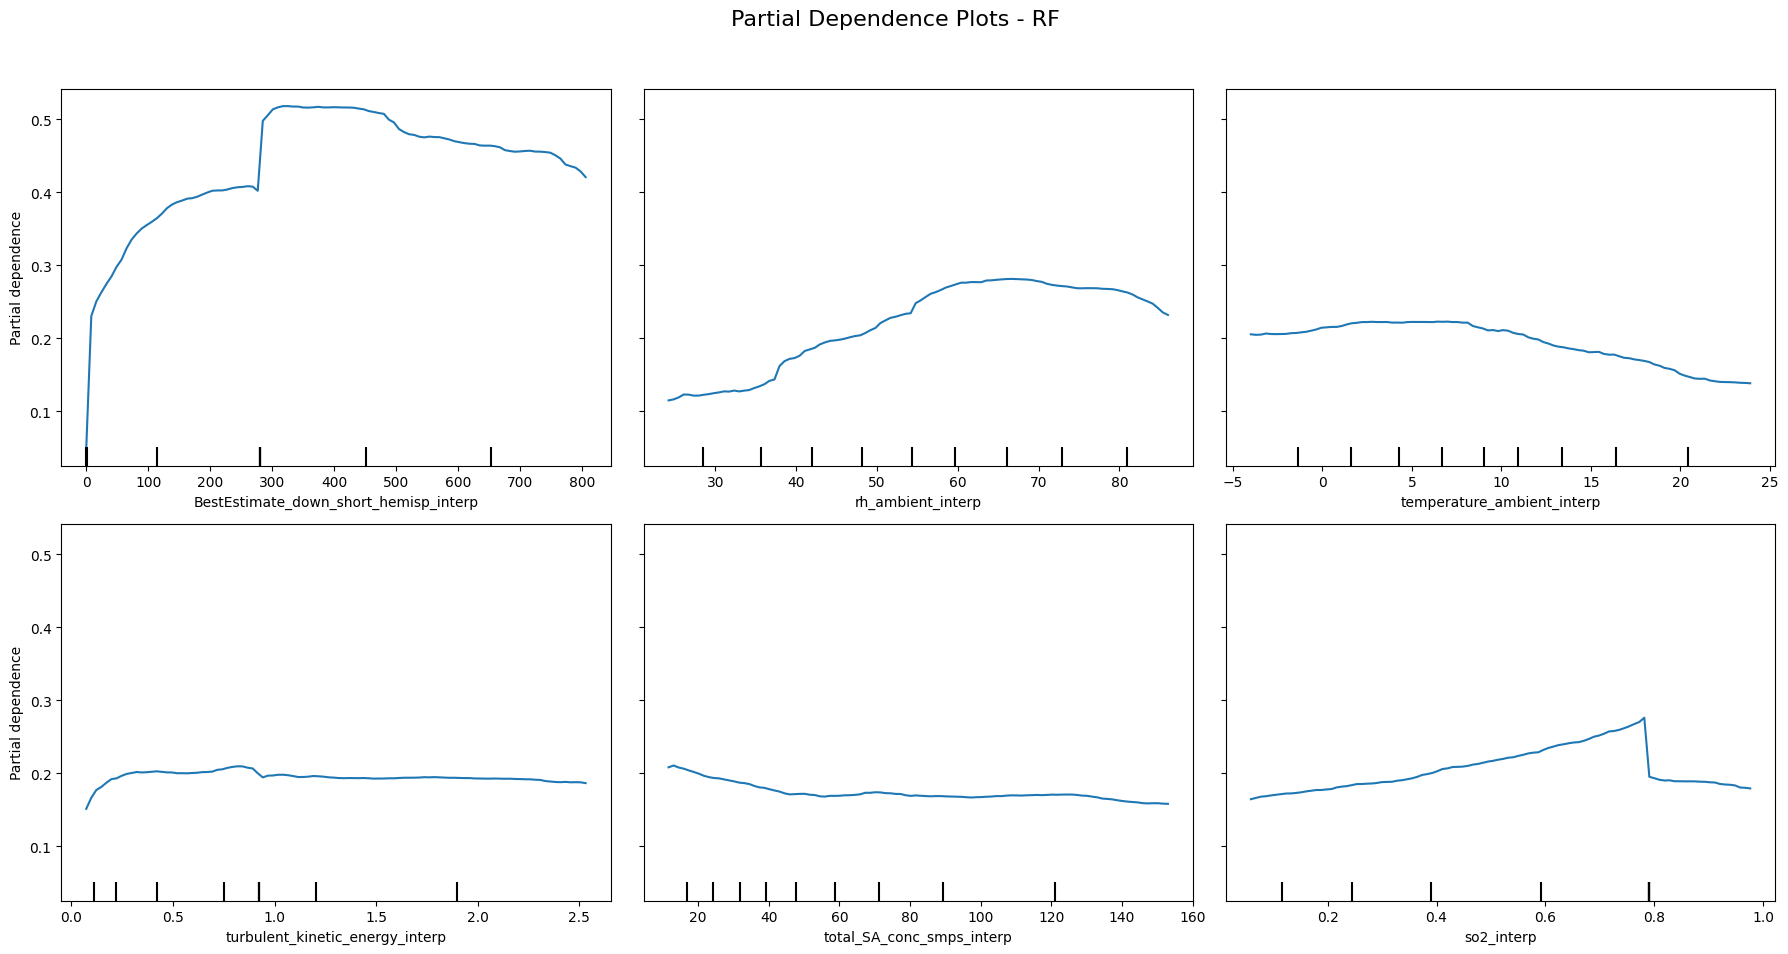

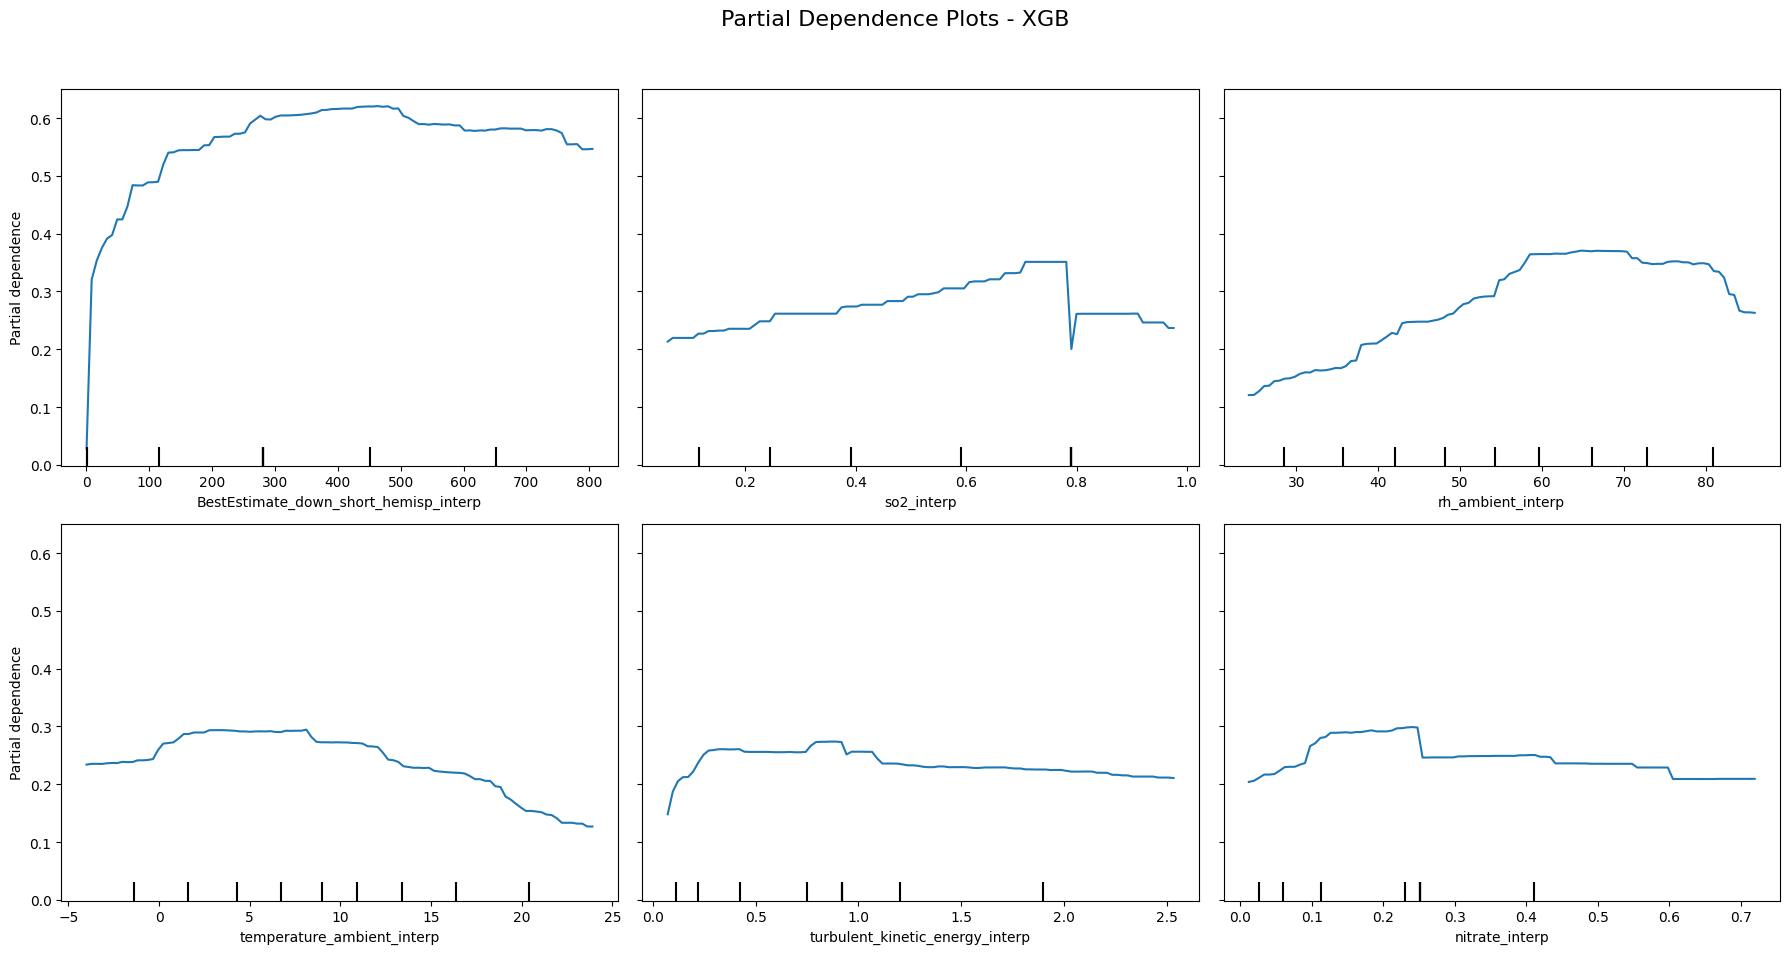

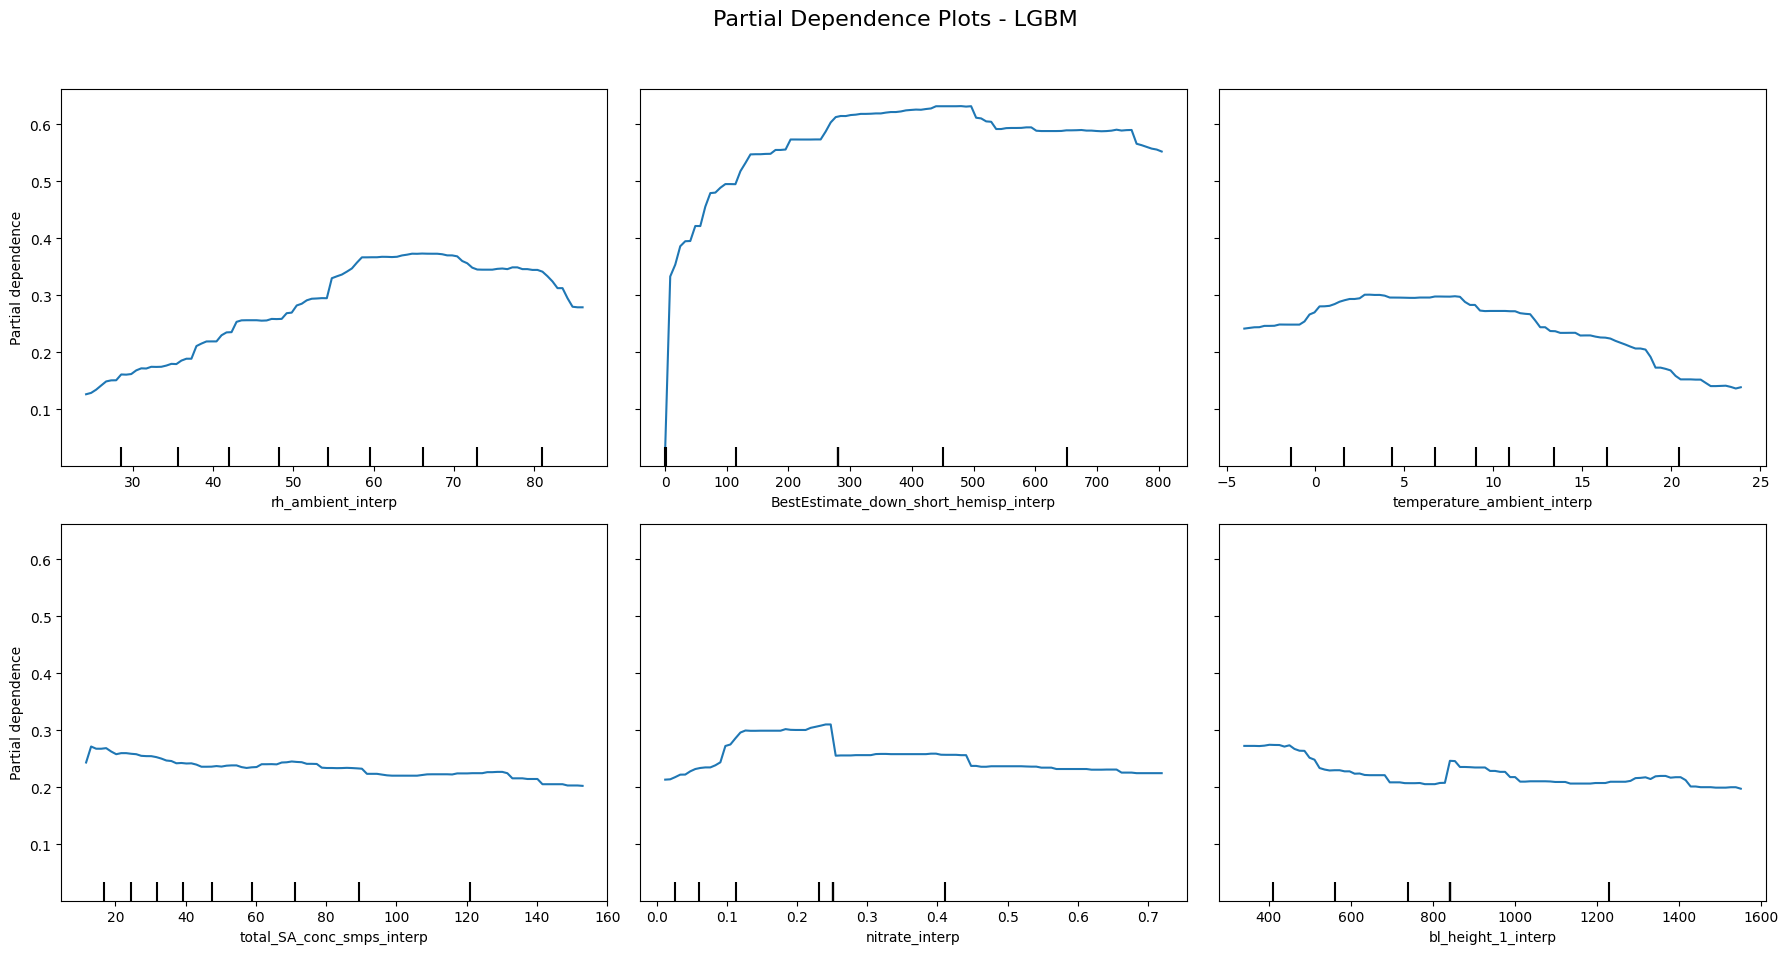

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

features_columns = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]

def get_top6_features(model, feature_names):
    importances = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    return importance_df['Feature'].head(6).tolist()

for model_name in ['RF', 'XGB', 'LGBM']:
    model = all_predictions[model_name]['model']
    top6_features = get_top6_features(model, features_columns)

    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10.8, 6))
    PartialDependenceDisplay.from_estimator(
        model, X_train, features=top6_features, ax=ax
    )
    plt.suptitle(f"Partial Dependence Plots - {model_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


Training RF...
Training XGB...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:30:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training LGBM...
[LightGBM] [Info] Number of positive: 47480, number of negative: 47480
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 94960, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training MLP...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



Confusion Matrix - RF
[[19555   688]
 [  520  3858]]


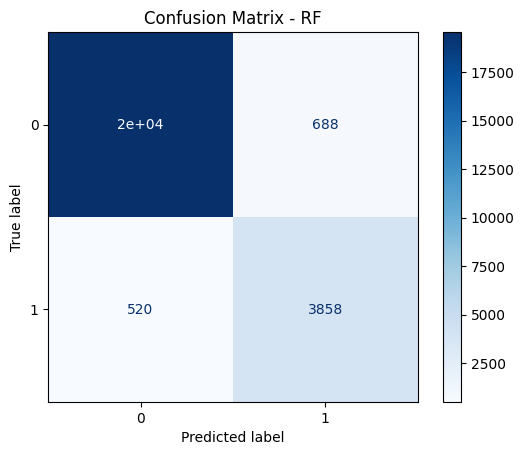

Classification Report - RF
              precision    recall  f1-score       support
0.0            0.974097  0.966013  0.970038  20243.000000
1.0            0.848658  0.881224  0.864635   4378.000000
accuracy       0.950936  0.950936  0.950936      0.950936
macro avg      0.911378  0.923619  0.917336  24621.000000
weighted avg   0.951792  0.950936  0.951296  24621.000000

Confusion Matrix - XGB
[[18078  2165]
 [  777  3601]]


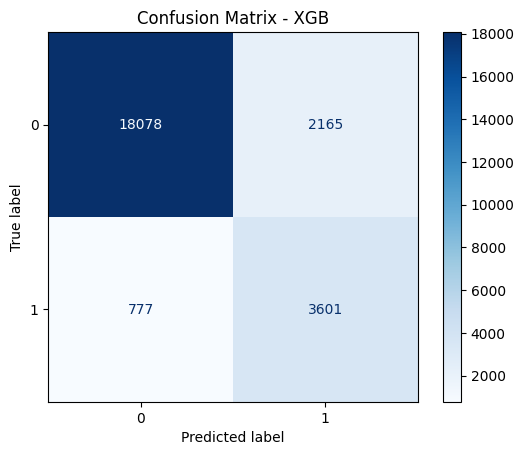

Classification Report - XGB
              precision    recall  f1-score       support
0.0            0.958791  0.893049  0.924753  20243.000000
1.0            0.624523  0.822522  0.709976   4378.000000
accuracy       0.880509  0.880509  0.880509      0.880509
macro avg      0.791657  0.857786  0.817365  24621.000000
weighted avg   0.899353  0.880509  0.886562  24621.000000

Confusion Matrix - LGBM
[[17958  2285]
 [  803  3575]]


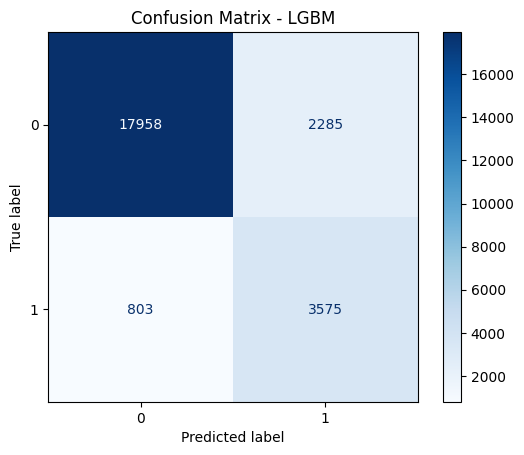

Classification Report - LGBM
              precision    recall  f1-score       support
0.0            0.957198  0.887121  0.920829  20243.000000
1.0            0.610068  0.816583  0.698379   4378.000000
accuracy       0.874579  0.874579  0.874579      0.874579
macro avg      0.783633  0.851852  0.809604  24621.000000
weighted avg   0.895473  0.874579  0.881274  24621.000000

Confusion Matrix - SVM
[[ 2302 17941]
 [  220  4158]]


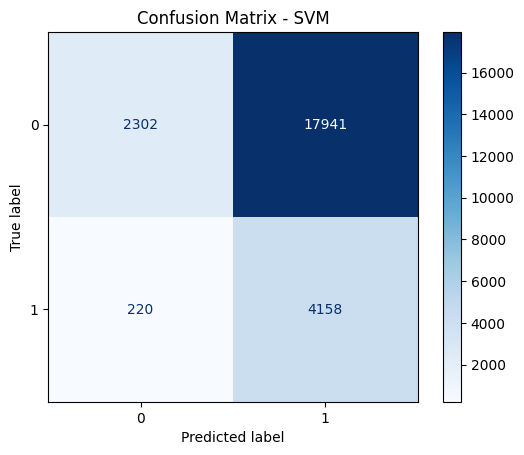

Classification Report - SVM
              precision    recall  f1-score       support
0.0            0.912768  0.113718  0.202240  20243.000000
1.0            0.188153  0.949749  0.314084   4378.000000
accuracy       0.262378  0.262378  0.262378      0.262378
macro avg      0.550460  0.531734  0.258162  24621.000000
weighted avg   0.783920  0.262378  0.222128  24621.000000

Confusion Matrix - MLP
[[18461  1782]
 [ 2171  2207]]


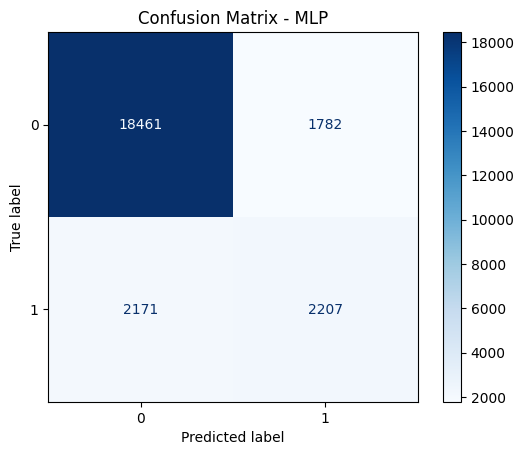

Classification Report - MLP
              precision    recall  f1-score       support
0.0            0.894775  0.911970  0.903291  20243.000000
1.0            0.553271  0.504111  0.527549   4378.000000
accuracy       0.839446  0.839446  0.839446      0.839446
macro avg      0.724023  0.708041  0.715420  24621.000000
weighted avg   0.834050  0.839446  0.836478  24621.000000


In [ ]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, recall_score, precision_score, roc_auc_score,
    confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE

def mark_pre_npf_signal(df, flag_column='flag3', window= 48):
    signal = np.zeros(len(df))
    for i in range(1, len(df)):
        if df[flag_column].iat[i] == 1 and df[flag_column].iat[i-1] == 0:
            start = max(0, i - window)
            signal[start:i] = 1
    return pd.Series(signal, index=df.index, name='npf_signal')

df = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')
df['npf_signal'] = mark_pre_npf_signal(df, window=48)

features = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]
X = df[features].fillna(df[features].mean())
y = df['npf_signal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_tr, y_tr = SMOTE(random_state=42).fit_resample(X_train, y_train)


from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

models = {
    'RF': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGB': XGBClassifier(max_depth=6, learning_rate=0.1, n_estimators=100,
                         eval_metric='logloss', use_label_encoder=False, random_state=42),
    'LGBM': LGBMClassifier(max_depth=6, learning_rate=0.1, n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, C=1.0, gamma='scale', max_iter=1000, random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, random_state=42)
}

results = []
all_predictions = {}

for name, model in models.items():
    print(f"Training {name}...")

    t0 = time.time()
    model.fit(X_tr, y_tr)
    train_time = time.time() - t0

    t1 = time.time()
    preds = model.predict(X_test)
    infer_time = time.time() - t1

    probs = model.predict_proba(X_test)[:, 1]
    cm = confusion_matrix(y_test, preds)
    cr = classification_report(y_test, preds, digits=4, output_dict=True)

    all_predictions[name] = {
        'model': model,
        'preds': preds,
        'probs': probs,
        'conf_matrix': cm,
        'class_report': cr
    }

    results.append({
        'Model': name,
        'F1': f1_score(y_test, preds),
        'Recall': recall_score(y_test, preds),
        'Precision': precision_score(y_test, preds),
        'AUC': roc_auc_score(y_test, probs),
        'TrainTime': train_time,
        'InferTime': infer_time,
        'Hyperparams': len(model.get_params()),
        'HasFeatureImp': hasattr(model, 'feature_importances_')
    })

df_res = pd.DataFrame(results)

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for model_name, items in all_predictions.items():
    cm = items['conf_matrix']
    print(f"\nConfusion Matrix - {model_name}")
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    print(f"Classification Report - {model_name}")
    print(pd.DataFrame(items['class_report']).T)

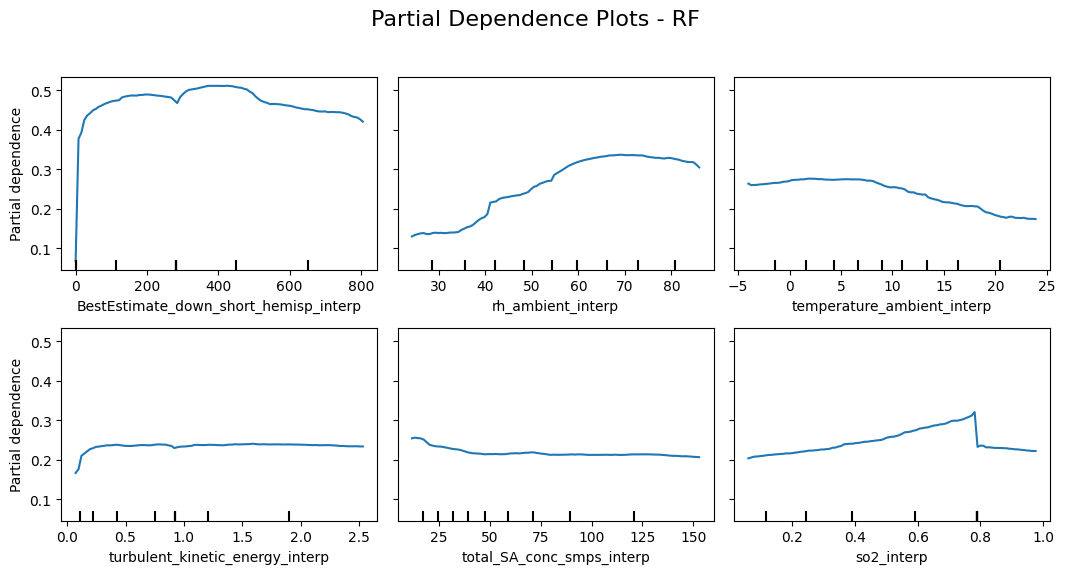

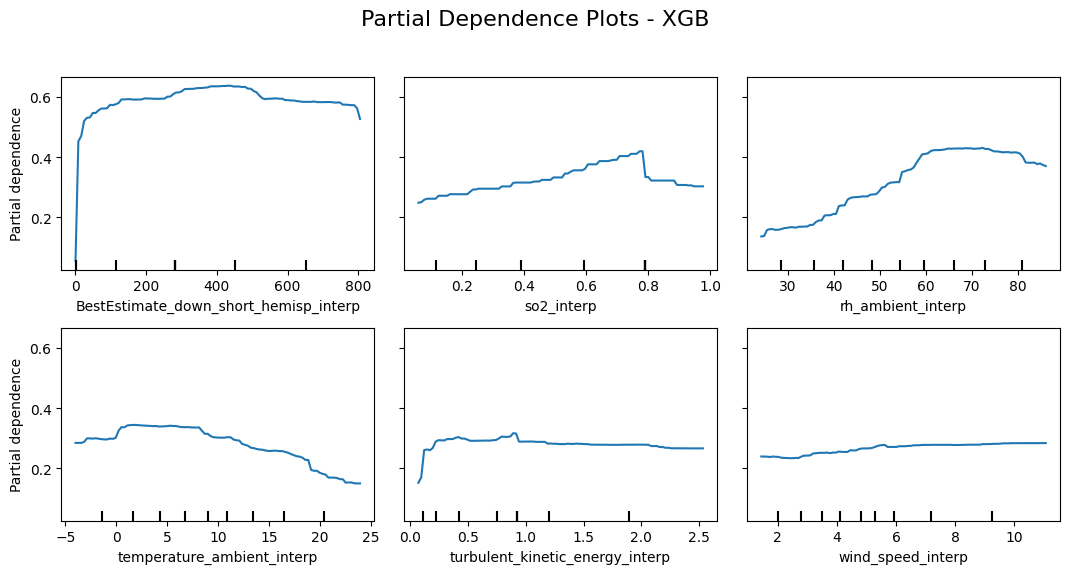

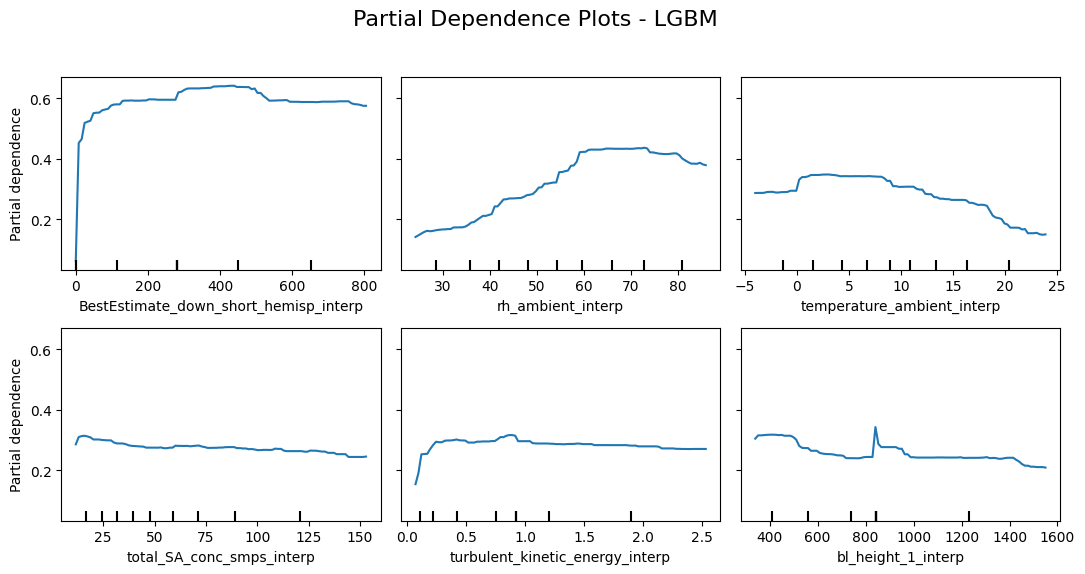

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

features_columns = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]

def get_top6_features(model, feature_names):
    importances = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    return importance_df['Feature'].head(6).tolist()

for model_name in ['RF', 'XGB', 'LGBM']:
    model = all_predictions[model_name]['model']
    top6_features = get_top6_features(model, features_columns)

    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10.8, 6))
    PartialDependenceDisplay.from_estimator(
        model, X_train, features=top6_features, ax=ax
    )
    plt.suptitle(f"Partial Dependence Plots - {model_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


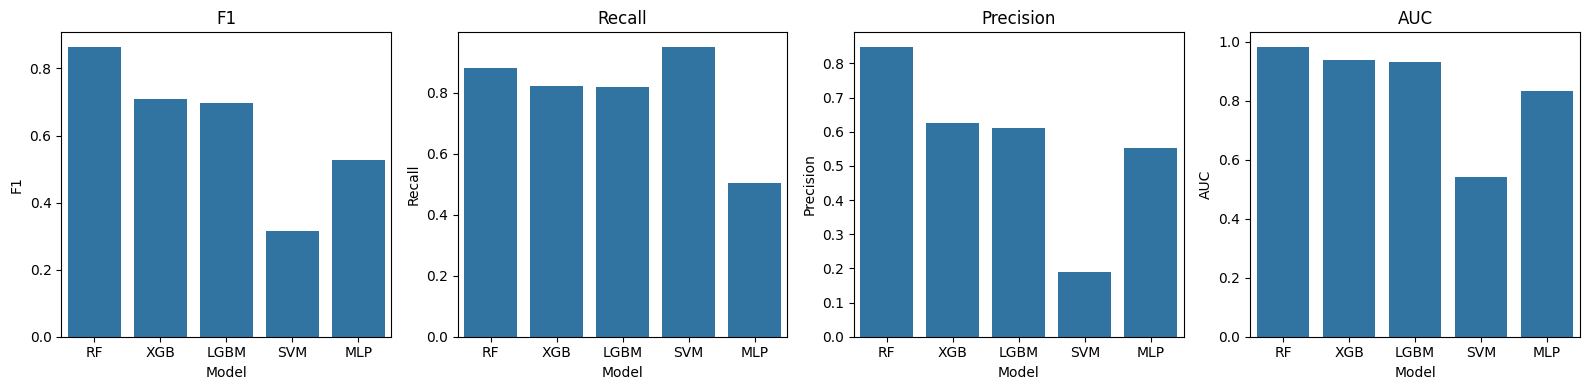

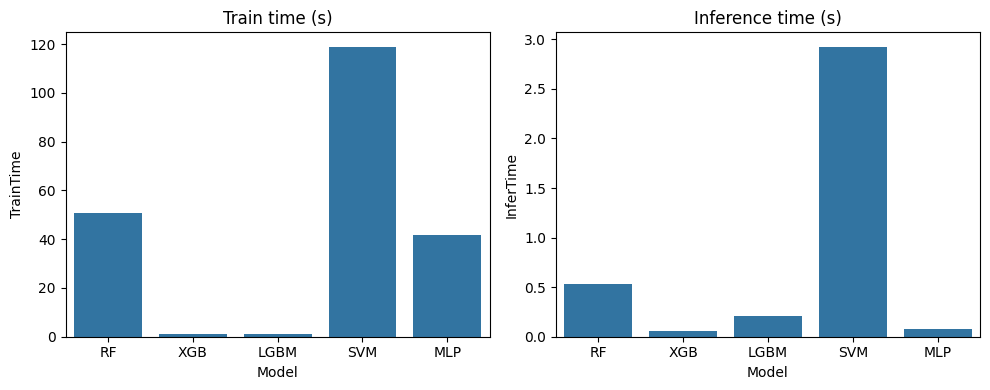

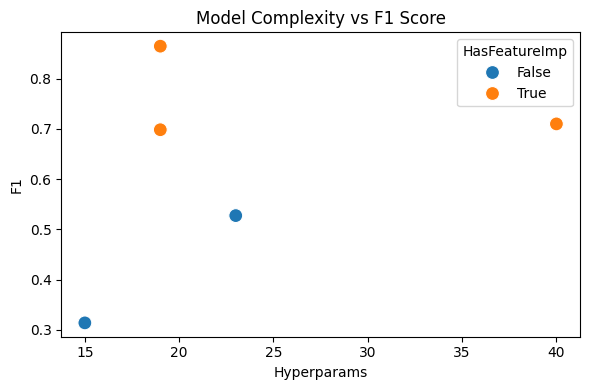

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bar plot for performance metrics
metrics = ['F1','Recall','Precision','AUC']
fig, axes = plt.subplots(1, len(metrics), figsize=(16,4))
for ax, m in zip(axes, metrics):
    sns.barplot(data=df_res, x='Model', y=m, ax=ax)
    ax.set_title(m)
plt.tight_layout()
plt.show()

# Training & inference time
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.barplot(data=df_res, x='Model', y='TrainTime', ax=ax[0]).set_title('Train time (s)')
sns.barplot(data=df_res, x='Model', y='InferTime', ax=ax[1]).set_title('Inference time (s)')
plt.tight_layout()
plt.show()

# Hyperparameter count vs interpretability
fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(data=df_res, x='Hyperparams', y='F1', hue='HasFeatureImp', s=100, ax=ax)
ax.set_title('Model Complexity vs F1 Score')
plt.tight_layout()
plt.show()

Training RF...
Training XGB...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:34:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training LGBM...
[LightGBM] [Info] Number of positive: 42535, number of negative: 42535
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 85070, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training MLP...

Confusion Matrix - RF
[[17479   590]
 [  688  5864]]


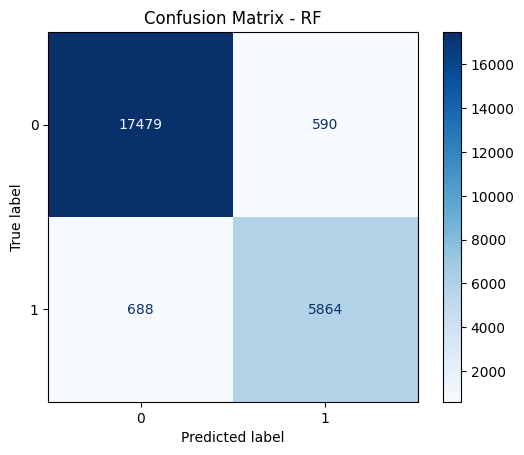

Classification Report - RF
              precision    recall  f1-score       support
0.0            0.962129  0.967347  0.964731  18069.000000
1.0            0.908584  0.894994  0.901738   6552.000000
accuracy       0.948093  0.948093  0.948093      0.948093
macro avg      0.935356  0.931171  0.933234  24621.000000
weighted avg   0.947880  0.948093  0.947968  24621.000000

Confusion Matrix - XGB
[[15786  2283]
 [ 1470  5082]]


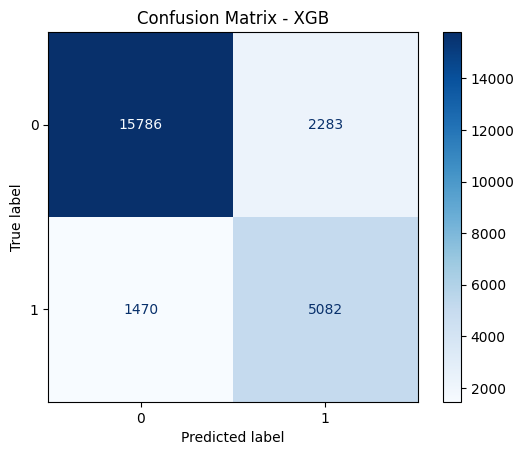

Classification Report - XGB
              precision    recall  f1-score       support
0.0            0.914812  0.873651  0.893758  18069.000000
1.0            0.690020  0.775641  0.730330   6552.000000
accuracy       0.847569  0.847569  0.847569      0.847569
macro avg      0.802416  0.824646  0.812044  24621.000000
weighted avg   0.854992  0.847569  0.850267  24621.000000

Confusion Matrix - LGBM
[[15653  2416]
 [ 1651  4901]]


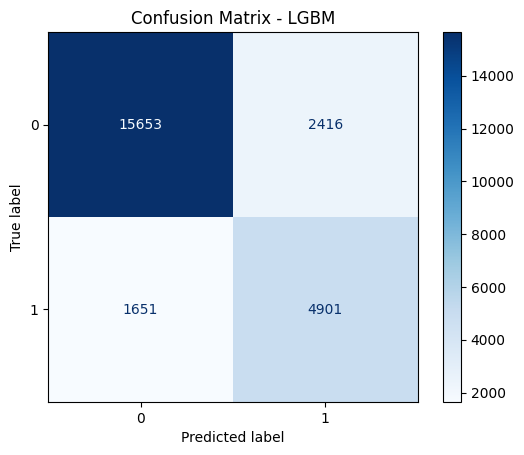

Classification Report - LGBM
              precision    recall  f1-score       support
0.0            0.904589  0.866290  0.885025  18069.000000
1.0            0.669810  0.748016  0.706756   6552.000000
accuracy       0.834816  0.834816  0.834816      0.834816
macro avg      0.787199  0.807153  0.795891  24621.000000
weighted avg   0.842111  0.834816  0.837585  24621.000000

Confusion Matrix - SVM
[[ 2293 15776]
 [  328  6224]]


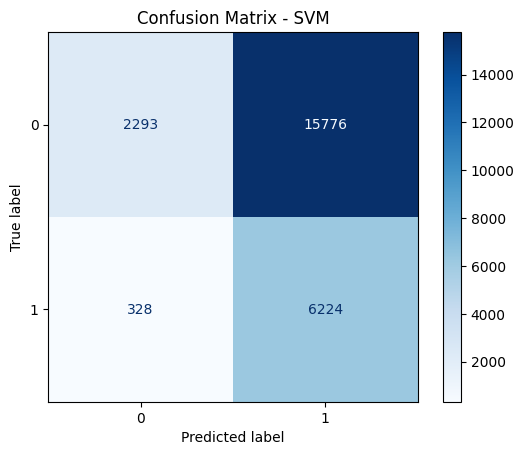

Classification Report - SVM
              precision    recall  f1-score       support
0.0            0.874857  0.126902  0.221653  18069.000000
1.0            0.282909  0.949939  0.435976   6552.000000
accuracy       0.345924  0.345924  0.345924      0.345924
macro avg      0.578883  0.538421  0.328815  24621.000000
weighted avg   0.717331  0.345924  0.278688  24621.000000

Confusion Matrix - MLP
[[12995  5074]
 [ 1785  4767]]


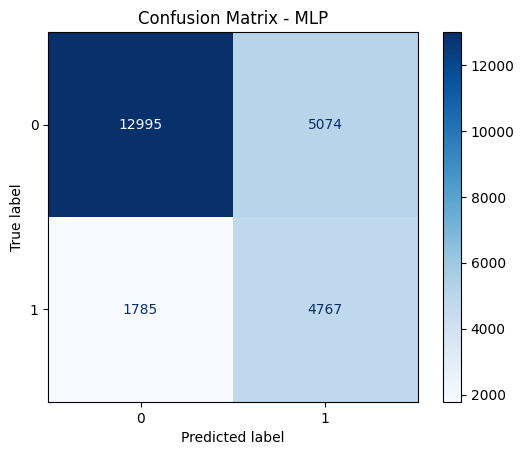

Classification Report - MLP
              precision    recall  f1-score       support
0.0            0.879229  0.719188  0.791196  18069.000000
1.0            0.484402  0.727564  0.581590   6552.000000
accuracy       0.721417  0.721417  0.721417      0.721417
macro avg      0.681815  0.723376  0.686393  24621.000000
weighted avg   0.774160  0.721417  0.735417  24621.000000


In [ ]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, recall_score, precision_score, roc_auc_score,
    confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE

def mark_pre_npf_signal(df, flag_column='flag3', window= 72):
    signal = np.zeros(len(df))
    for i in range(1, len(df)):
        if df[flag_column].iat[i] == 1 and df[flag_column].iat[i-1] == 0:
            start = max(0, i - window)
            signal[start:i] = 1
    return pd.Series(signal, index=df.index, name='npf_signal')

df = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')
df['npf_signal'] = mark_pre_npf_signal(df, window= 72)

features = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]
X = df[features].fillna(df[features].mean())
y = df['npf_signal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_tr, y_tr = SMOTE(random_state=42).fit_resample(X_train, y_train)


from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

models = {
    'RF': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGB': XGBClassifier(max_depth=6, learning_rate=0.1, n_estimators=100,
                         eval_metric='logloss', use_label_encoder=False, random_state=42),
    'LGBM': LGBMClassifier(max_depth=6, learning_rate=0.1, n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, C=1.0, gamma='scale', max_iter=1000, random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, random_state=42)
}

results = []
all_predictions = {}

for name, model in models.items():
    print(f"Training {name}...")

    t0 = time.time()
    model.fit(X_tr, y_tr)
    train_time = time.time() - t0

    t1 = time.time()
    preds = model.predict(X_test)
    infer_time = time.time() - t1

    probs = model.predict_proba(X_test)[:, 1]
    cm = confusion_matrix(y_test, preds)
    cr = classification_report(y_test, preds, digits=4, output_dict=True)

    all_predictions[name] = {
        'model': model,
        'preds': preds,
        'probs': probs,
        'conf_matrix': cm,
        'class_report': cr
    }

    results.append({
        'Model': name,
        'F1': f1_score(y_test, preds),
        'Recall': recall_score(y_test, preds),
        'Precision': precision_score(y_test, preds),
        'AUC': roc_auc_score(y_test, probs),
        'TrainTime': train_time,
        'InferTime': infer_time,
        'Hyperparams': len(model.get_params()),
        'HasFeatureImp': hasattr(model, 'feature_importances_')
    })

df_res = pd.DataFrame(results)

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for model_name, items in all_predictions.items():
    cm = items['conf_matrix']
    print(f"\nConfusion Matrix - {model_name}")
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    print(f"Classification Report - {model_name}")
    print(pd.DataFrame(items['class_report']).T)

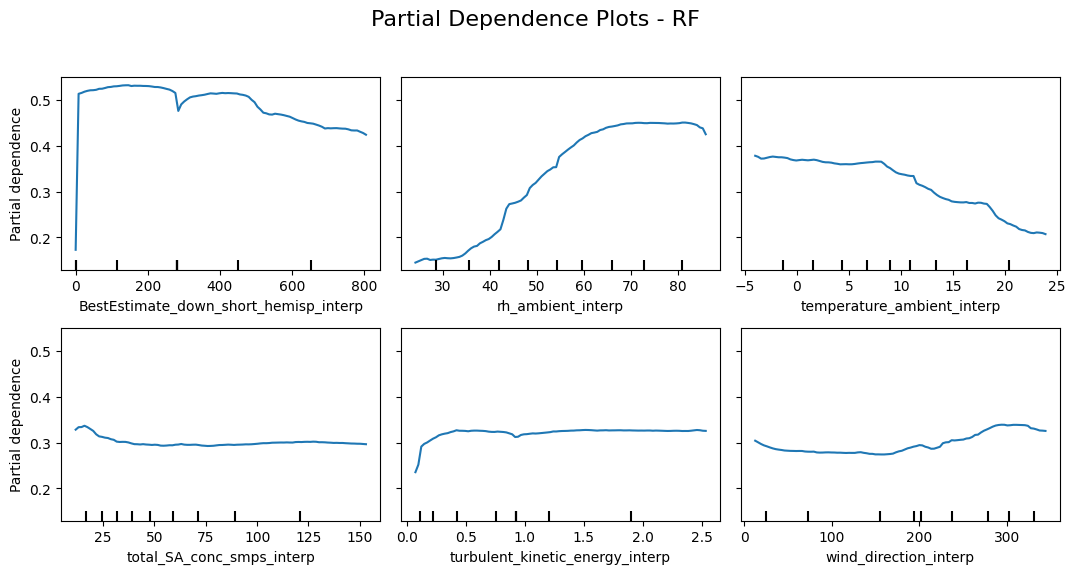

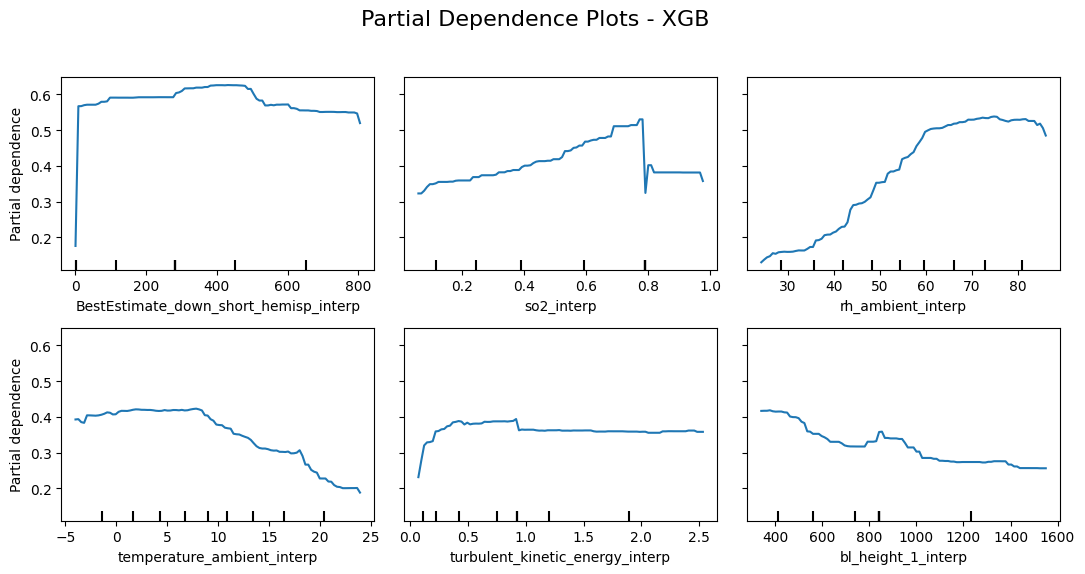

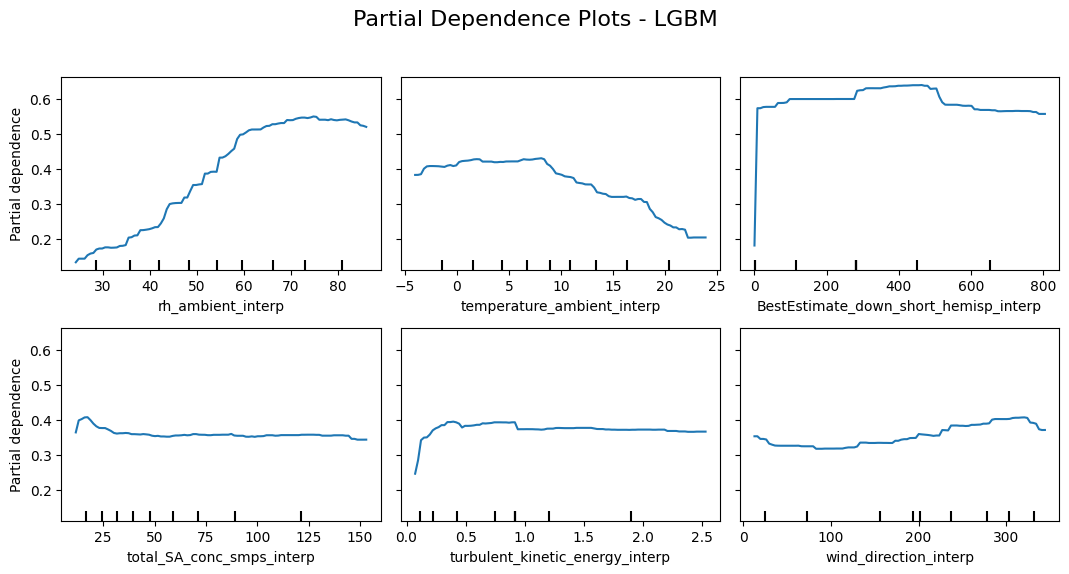

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

features_columns = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]

def get_top6_features(model, feature_names):
    importances = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    return importance_df['Feature'].head(6).tolist()

for model_name in ['RF', 'XGB', 'LGBM']:
    model = all_predictions[model_name]['model']
    top6_features = get_top6_features(model, features_columns)

    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10.8, 6))
    PartialDependenceDisplay.from_estimator(
        model, X_train, features=top6_features, ax=ax
    )
    plt.suptitle(f"Partial Dependence Plots - {model_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

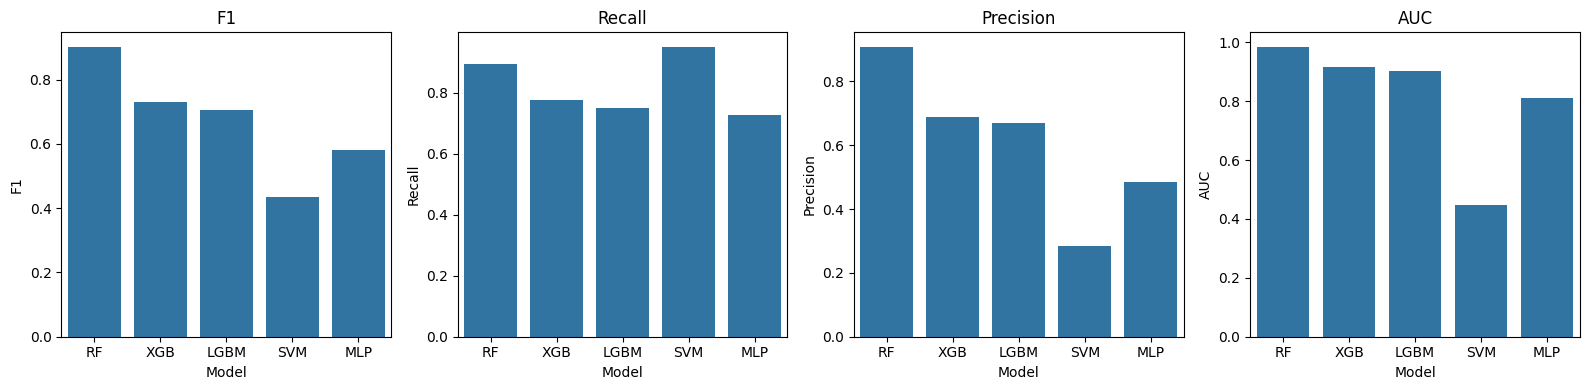

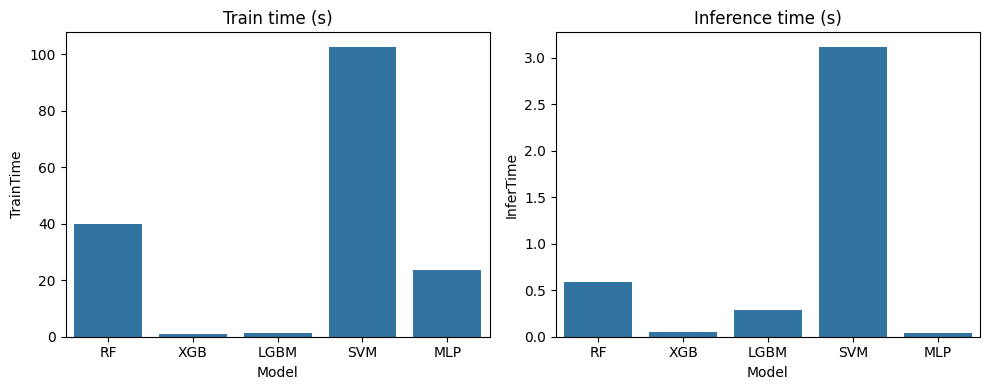

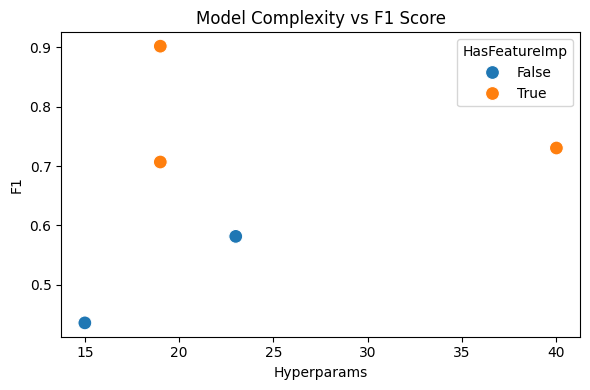

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bar plot for performance metrics
metrics = ['F1','Recall','Precision','AUC']
fig, axes = plt.subplots(1, len(metrics), figsize=(16,4))
for ax, m in zip(axes, metrics):
    sns.barplot(data=df_res, x='Model', y=m, ax=ax)
    ax.set_title(m)
plt.tight_layout()
plt.show()

# Training & inference time
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.barplot(data=df_res, x='Model', y='TrainTime', ax=ax[0]).set_title('Train time (s)')
sns.barplot(data=df_res, x='Model', y='InferTime', ax=ax[1]).set_title('Inference time (s)')
plt.tight_layout()
plt.show()

# Hyperparameter count vs interpretability
fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(data=df_res, x='Hyperparams', y='F1', hue='HasFeatureImp', s=100, ax=ax)
ax.set_title('Model Complexity vs F1 Score')
plt.tight_layout()
plt.show()

Training RF...
Training XGB...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:56:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training LGBM...
[LightGBM] [Info] Number of positive: 37627, number of negative: 37627
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 75254, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training MLP...

Confusion Matrix - RF
[[15398   579]
 [  620  8024]]


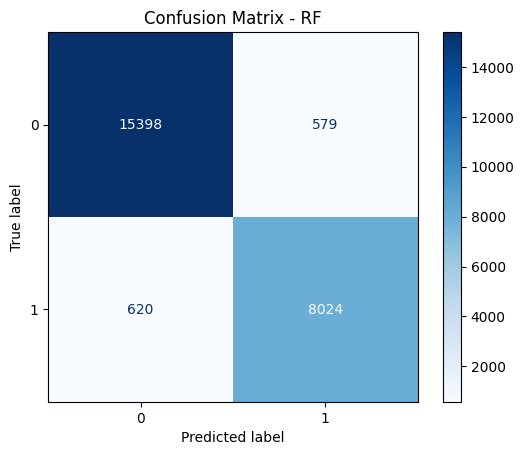

Classification Report - RF
              precision    recall  f1-score       support
0.0            0.961294  0.963760  0.962525  15977.000000
1.0            0.932698  0.928274  0.930481   8644.000000
accuracy       0.951302  0.951302  0.951302      0.951302
macro avg      0.946996  0.946017  0.946503  24621.000000
weighted avg   0.951254  0.951302  0.951275  24621.000000

Confusion Matrix - XGB
[[13379  2598]
 [ 1603  7041]]


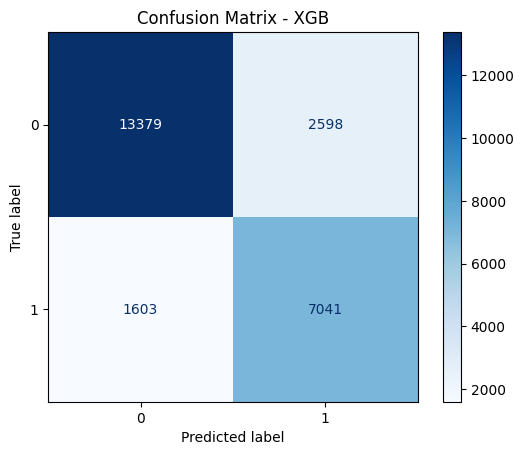

Classification Report - XGB
              precision    recall  f1-score       support
0.0            0.893005  0.837391  0.864304  15977.000000
1.0            0.730470  0.814553  0.770224   8644.000000
accuracy       0.829373  0.829373  0.829373      0.829373
macro avg      0.811737  0.825972  0.817264  24621.000000
weighted avg   0.835942  0.829373  0.831274  24621.000000

Confusion Matrix - LGBM
[[13195  2782]
 [ 1775  6869]]


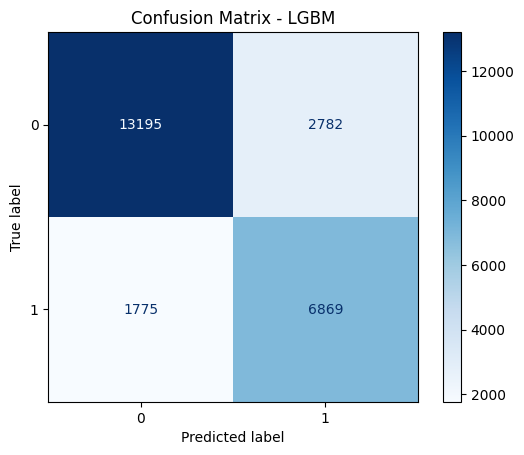

Classification Report - LGBM
              precision    recall  f1-score       support
0.0            0.881430  0.825875  0.852748  15977.000000
1.0            0.711740  0.794655  0.750916   8644.000000
accuracy       0.814914  0.814914  0.814914      0.814914
macro avg      0.796585  0.810265  0.801832  24621.000000
weighted avg   0.821854  0.814914  0.816997  24621.000000

Confusion Matrix - SVM
[[ 4223 11754]
 [  797  7847]]


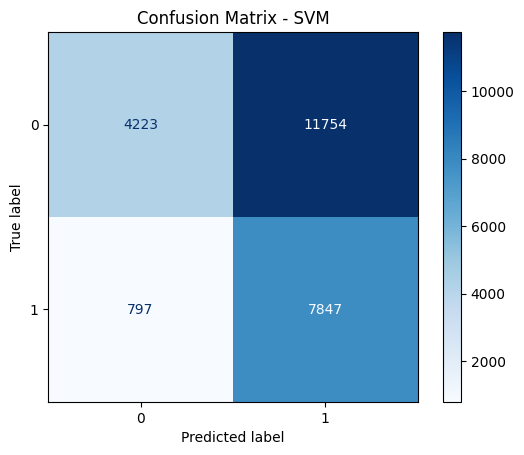

Classification Report - SVM
              precision    recall  f1-score       support
0.0            0.841235  0.264317  0.402248  15977.000000
1.0            0.400337  0.907797  0.555638   8644.000000
accuracy       0.490232  0.490232  0.490232      0.490232
macro avg      0.620786  0.586057  0.478943  24621.000000
weighted avg   0.686443  0.490232  0.456101  24621.000000

Confusion Matrix - MLP
[[10118  5859]
 [ 1832  6812]]


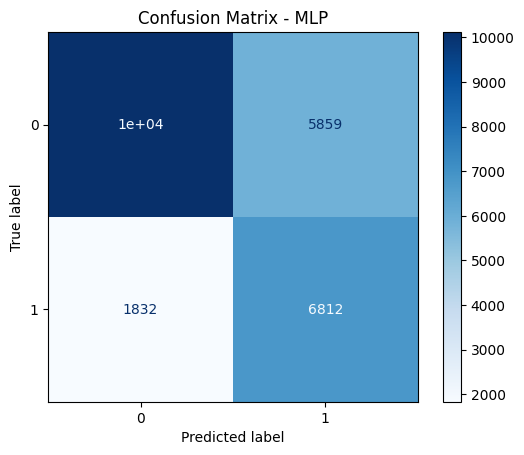

Classification Report - MLP
              precision    recall  f1-score       support
0.0            0.846695  0.633285  0.724603  15977.000000
1.0            0.537606  0.788061  0.639174   8644.000000
accuracy       0.687624  0.687624  0.687624      0.687624
macro avg      0.692150  0.710673  0.681889  24621.000000
weighted avg   0.738179  0.687624  0.694611  24621.000000


In [ ]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, recall_score, precision_score, roc_auc_score,
    confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE

def mark_pre_npf_signal(df, flag_column='flag3', window= 96):
    signal = np.zeros(len(df))
    for i in range(1, len(df)):
        if df[flag_column].iat[i] == 1 and df[flag_column].iat[i-1] == 0:
            start = max(0, i - window)
            signal[start:i] = 1
    return pd.Series(signal, index=df.index, name='npf_signal')

df = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')
df['npf_signal'] = mark_pre_npf_signal(df, window=96)

features = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]
X = df[features].fillna(df[features].mean())
y = df['npf_signal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_tr, y_tr = SMOTE(random_state=42).fit_resample(X_train, y_train)


from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

models = {
    'RF': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGB': XGBClassifier(max_depth=6, learning_rate=0.1, n_estimators=100,
                         eval_metric='logloss', use_label_encoder=False, random_state=42),
    'LGBM': LGBMClassifier(max_depth=6, learning_rate=0.1, n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, C=1.0, gamma='scale', max_iter=1000, random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, random_state=42)
}

results = []
all_predictions = {}

for name, model in models.items():
    print(f"Training {name}...")

    t0 = time.time()
    model.fit(X_tr, y_tr)
    train_time = time.time() - t0

    t1 = time.time()
    preds = model.predict(X_test)
    infer_time = time.time() - t1

    probs = model.predict_proba(X_test)[:, 1]
    cm = confusion_matrix(y_test, preds)
    cr = classification_report(y_test, preds, digits=4, output_dict=True)

    all_predictions[name] = {
        'model': model,
        'preds': preds,
        'probs': probs,
        'conf_matrix': cm,
        'class_report': cr
    }

    results.append({
        'Model': name,
        'F1': f1_score(y_test, preds),
        'Recall': recall_score(y_test, preds),
        'Precision': precision_score(y_test, preds),
        'AUC': roc_auc_score(y_test, probs),
        'TrainTime': train_time,
        'InferTime': infer_time,
        'Hyperparams': len(model.get_params()),
        'HasFeatureImp': hasattr(model, 'feature_importances_')
    })

df_res = pd.DataFrame(results)

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for model_name, items in all_predictions.items():
    cm = items['conf_matrix']
    print(f"\nConfusion Matrix - {model_name}")
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    print(f"Classification Report - {model_name}")
    print(pd.DataFrame(items['class_report']).T)

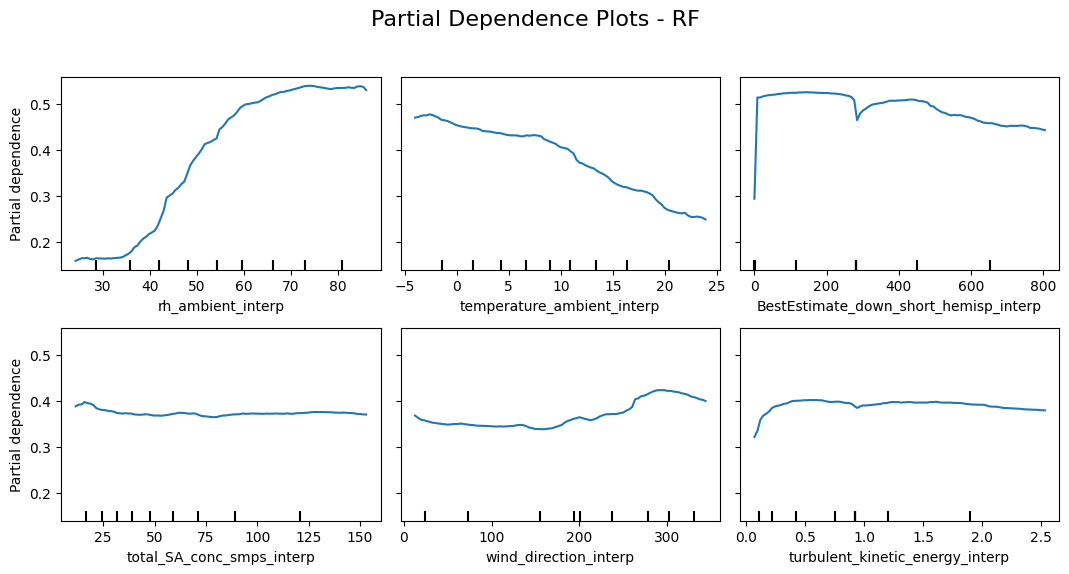

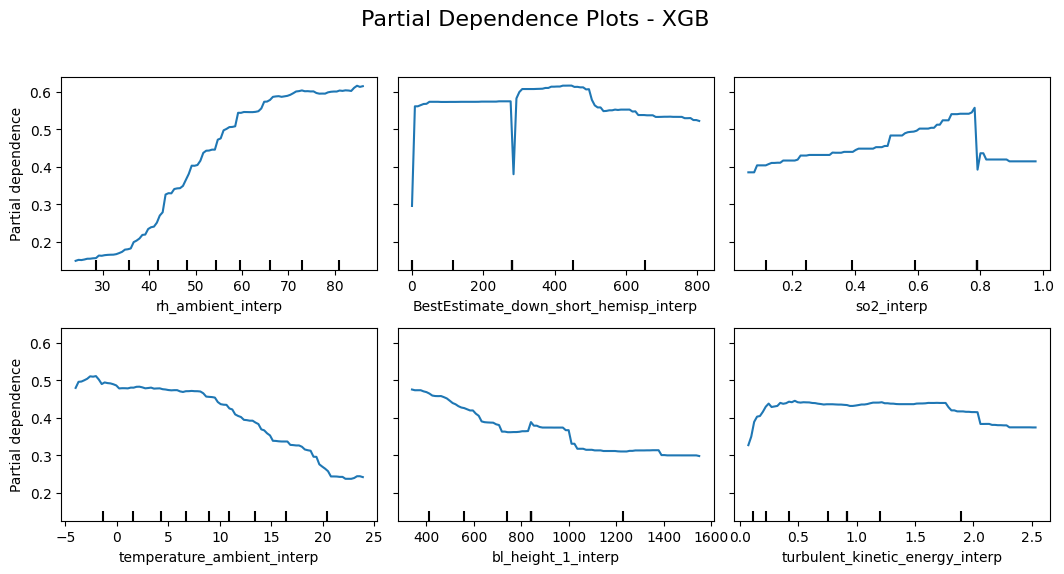

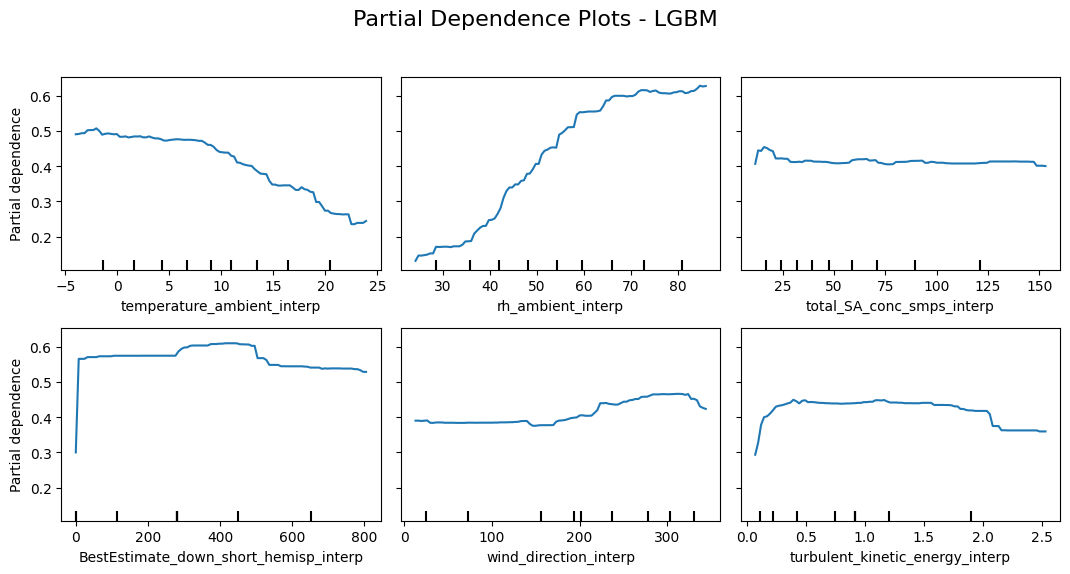

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

features_columns = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]

def get_top6_features(model, feature_names):
    importances = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    return importance_df['Feature'].head(6).tolist()

for model_name in ['RF', 'XGB', 'LGBM']:
    model = all_predictions[model_name]['model']
    top6_features = get_top6_features(model, features_columns)

    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10.8, 6))
    PartialDependenceDisplay.from_estimator(
        model, X_train, features=top6_features, ax=ax
    )
    plt.suptitle(f"Partial Dependence Plots - {model_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Training RF...
Training XGB...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:15:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training LGBM...
[LightGBM] [Info] Number of positive: 32791, number of negative: 32791
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 65582, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training MLP...

Confusion Matrix - RF
[[13514   439]
 [  462 10206]]


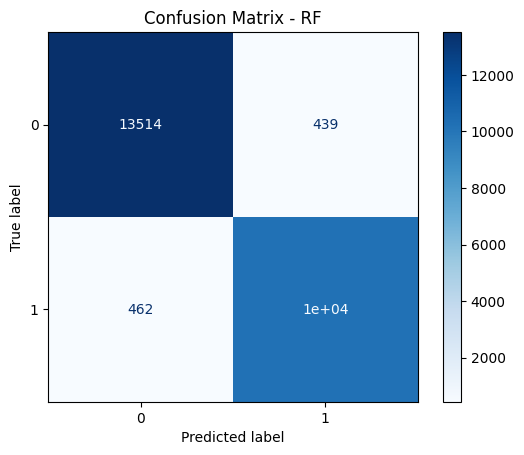

Classification Report - RF
              precision    recall  f1-score       support
0.0            0.966943  0.968537  0.967740  13953.000000
1.0            0.958760  0.956693  0.957725  10668.000000
accuracy       0.963405  0.963405  0.963405      0.963405
macro avg      0.962852  0.962615  0.962732  24621.000000
weighted avg   0.963398  0.963405  0.963401  24621.000000

Confusion Matrix - XGB
[[11313  2640]
 [ 1518  9150]]


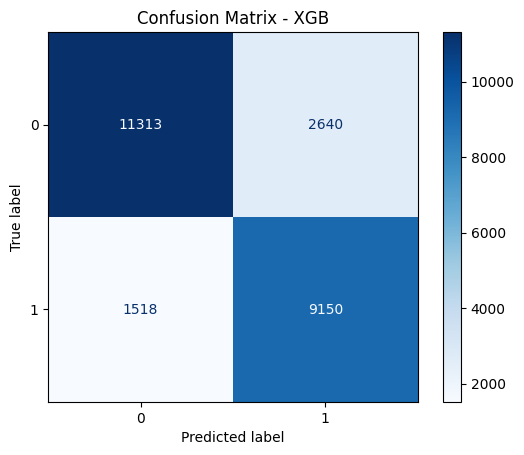

Classification Report - XGB
              precision    recall  f1-score      support
0.0            0.881693  0.810793  0.844758  13953.00000
1.0            0.776081  0.857705  0.814854  10668.00000
accuracy       0.831120  0.831120  0.831120      0.83112
macro avg      0.828887  0.834249  0.829806  24621.00000
weighted avg   0.835933  0.831120  0.831801  24621.00000

Confusion Matrix - LGBM
[[11070  2883]
 [ 1620  9048]]


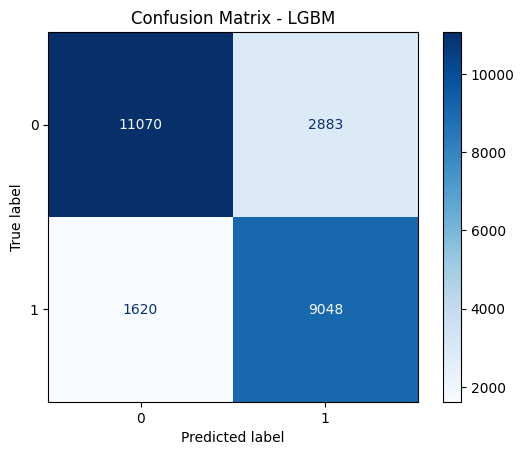

Classification Report - LGBM
              precision    recall  f1-score       support
0.0            0.872340  0.793378  0.830988  13953.000000
1.0            0.758361  0.848144  0.800743  10668.000000
accuracy       0.817107  0.817107  0.817107      0.817107
macro avg      0.815350  0.820761  0.815865  24621.000000
weighted avg   0.822954  0.817107  0.817883  24621.000000

Confusion Matrix - SVM
[[ 2773 11180]
 [  670  9998]]


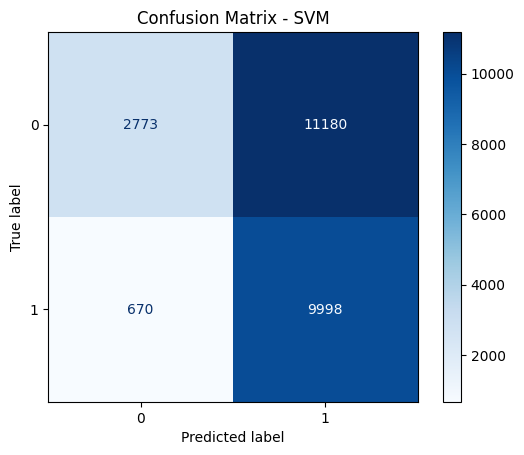

Classification Report - SVM
              precision    recall  f1-score       support
0.0            0.805402  0.198739  0.318809  13953.000000
1.0            0.472094  0.937195  0.627897  10668.000000
accuracy       0.518704  0.518704  0.518704      0.518704
macro avg      0.638748  0.567967  0.473353  24621.000000
weighted avg   0.660983  0.518704  0.452733  24621.000000

Confusion Matrix - MLP
[[9883 4070]
 [2929 7739]]


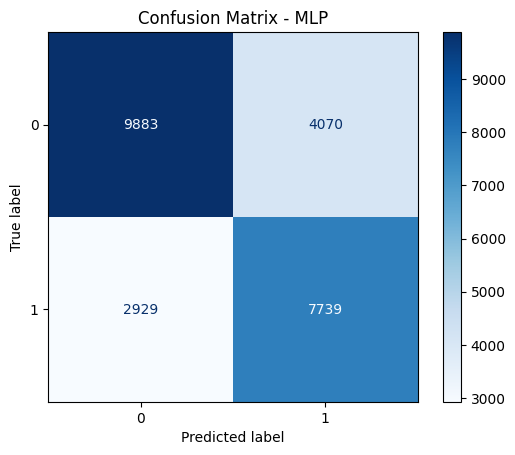

Classification Report - MLP
              precision    recall  f1-score      support
0.0            0.771386  0.708306  0.738502  13953.00000
1.0            0.655348  0.725441  0.688615  10668.00000
accuracy       0.715730  0.715730  0.715730      0.71573
macro avg      0.713367  0.716874  0.713558  24621.00000
weighted avg   0.721108  0.715730  0.716886  24621.00000


In [ ]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, recall_score, precision_score, roc_auc_score,
    confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE

def mark_pre_npf_signal(df, flag_column='flag3', window=120):
    signal = np.zeros(len(df))
    for i in range(1, len(df)):
        if df[flag_column].iat[i] == 1 and df[flag_column].iat[i-1] == 0:
            start = max(0, i - window)
            signal[start:i] = 1
    return pd.Series(signal, index=df.index, name='npf_signal')

df = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')
df['npf_signal'] = mark_pre_npf_signal(df, window=120)

features = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]
X = df[features].fillna(df[features].mean())
y = df['npf_signal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_tr, y_tr = SMOTE(random_state=42).fit_resample(X_train, y_train)


from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

models = {
    'RF': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGB': XGBClassifier(max_depth=6, learning_rate=0.1, n_estimators=100,
                         eval_metric='logloss', use_label_encoder=False, random_state=42),
    'LGBM': LGBMClassifier(max_depth=6, learning_rate=0.1, n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, C=1.0, gamma='scale', max_iter=1000, random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, random_state=42)
}

results = []
all_predictions = {}

for name, model in models.items():
    print(f"Training {name}...")

    t0 = time.time()
    model.fit(X_tr, y_tr)
    train_time = time.time() - t0

    t1 = time.time()
    preds = model.predict(X_test)
    infer_time = time.time() - t1

    probs = model.predict_proba(X_test)[:, 1]
    cm = confusion_matrix(y_test, preds)
    cr = classification_report(y_test, preds, digits=4, output_dict=True)

    all_predictions[name] = {
        'model': model,
        'preds': preds,
        'probs': probs,
        'conf_matrix': cm,
        'class_report': cr
    }

    results.append({
        'Model': name,
        'F1': f1_score(y_test, preds),
        'Recall': recall_score(y_test, preds),
        'Precision': precision_score(y_test, preds),
        'AUC': roc_auc_score(y_test, probs),
        'TrainTime': train_time,
        'InferTime': infer_time,
        'Hyperparams': len(model.get_params()),
        'HasFeatureImp': hasattr(model, 'feature_importances_')
    })

df_res = pd.DataFrame(results)

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for model_name, items in all_predictions.items():
    cm = items['conf_matrix']
    print(f"\nConfusion Matrix - {model_name}")
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    print(f"Classification Report - {model_name}")
    print(pd.DataFrame(items['class_report']).T)

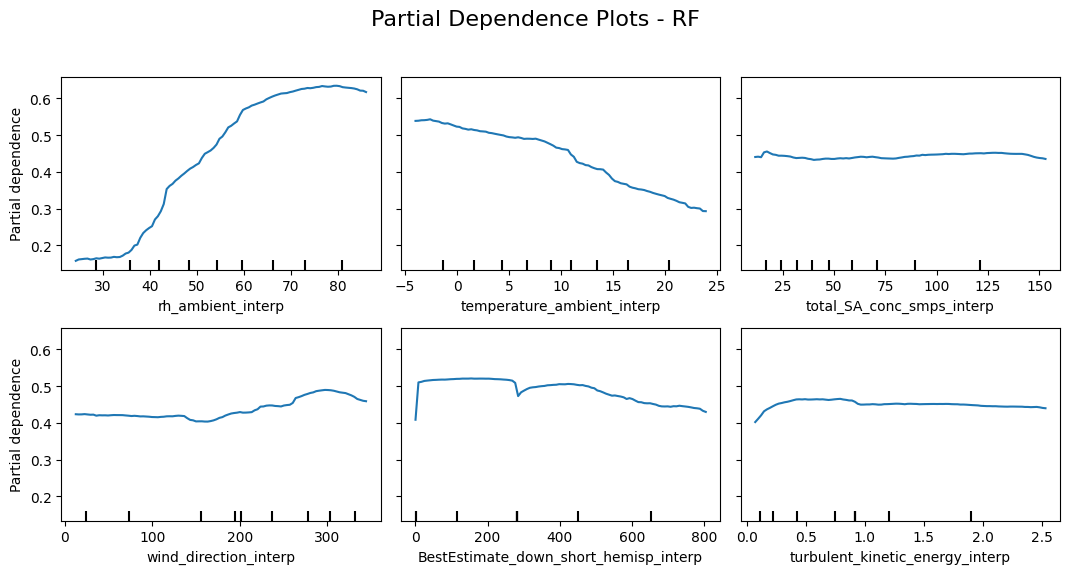

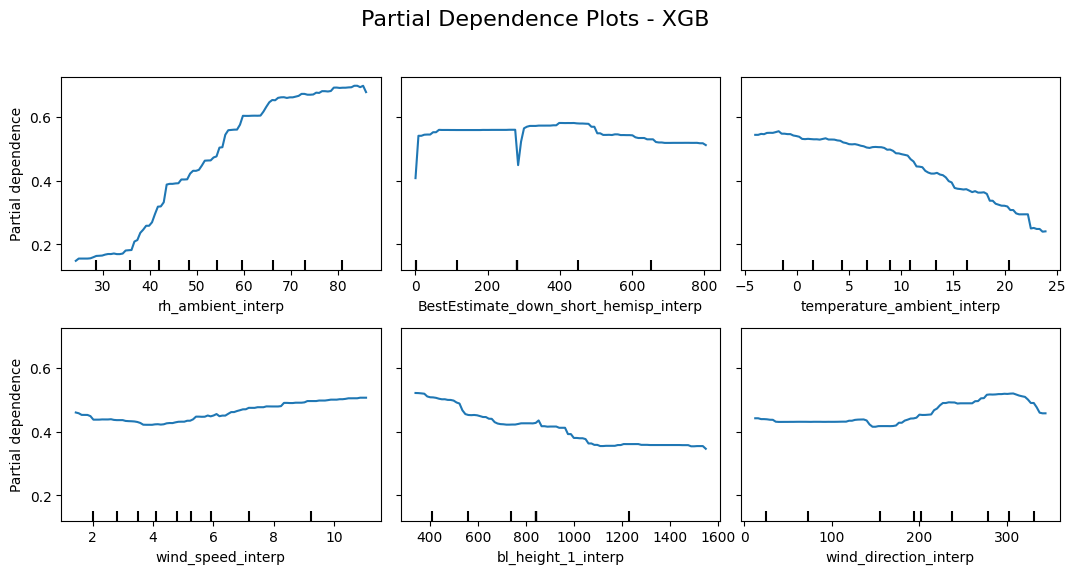

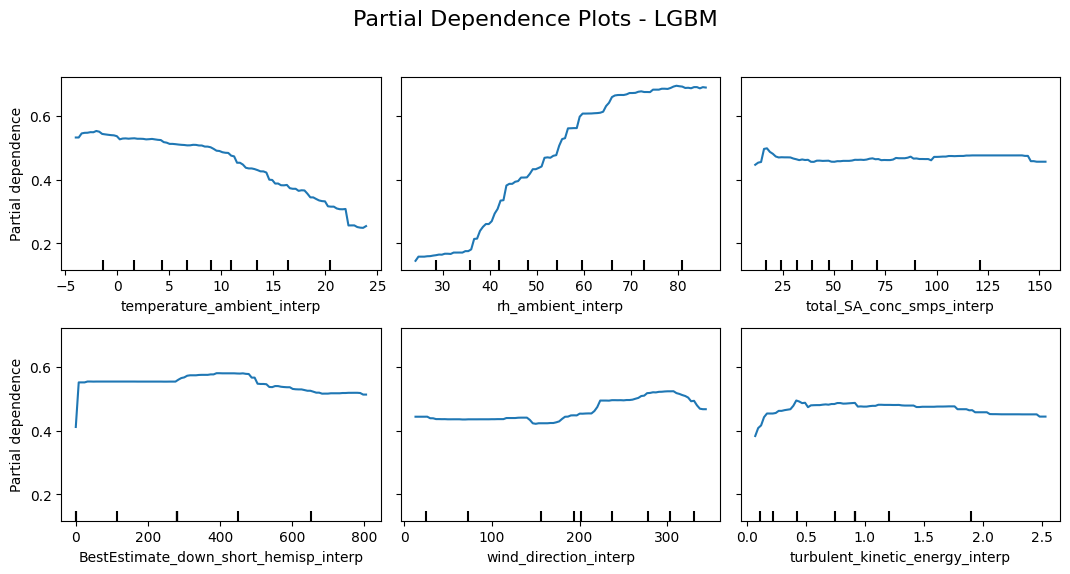

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

features_columns = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]

def get_top6_features(model, feature_names):
    importances = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    return importance_df['Feature'].head(6).tolist()

for model_name in ['RF', 'XGB', 'LGBM']:
    model = all_predictions[model_name]['model']
    top6_features = get_top6_features(model, features_columns)

    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10.8, 6))
    PartialDependenceDisplay.from_estimator(
        model, X_train, features=top6_features, ax=ax
    )
    plt.suptitle(f"Partial Dependence Plots - {model_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Training RF...
Training XGB...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:07:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training LGBM...
[LightGBM] [Info] Number of positive: 29475, number of negative: 29475
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 58950, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training MLP...

Confusion Matrix - RF
[[11579   377]
 [  434 12231]]


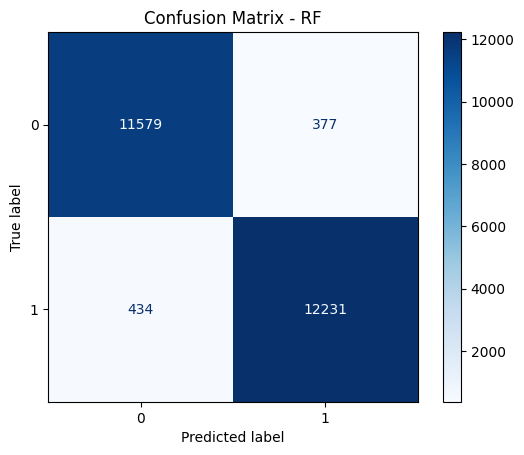

Classification Report - RF
              precision    recall  f1-score       support
0.0            0.963872  0.968468  0.966165  11956.000000
1.0            0.970098  0.965732  0.967910  12665.000000
accuracy       0.967061  0.967061  0.967061      0.967061
macro avg      0.966985  0.967100  0.967038  24621.000000
weighted avg   0.967075  0.967061  0.967063  24621.000000

Confusion Matrix - XGB
[[ 9635  2321]
 [ 1620 11045]]


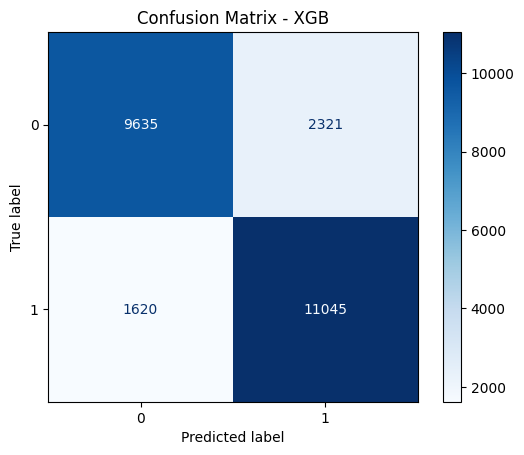

Classification Report - XGB
              precision    recall  f1-score       support
0.0            0.856064  0.805872  0.830210  11956.000000
1.0            0.826350  0.872088  0.848604  12665.000000
accuracy       0.839933  0.839933  0.839933      0.839933
macro avg      0.841207  0.838980  0.839407  24621.000000
weighted avg   0.840779  0.839933  0.839672  24621.000000

Confusion Matrix - LGBM
[[ 9538  2418]
 [ 1686 10979]]


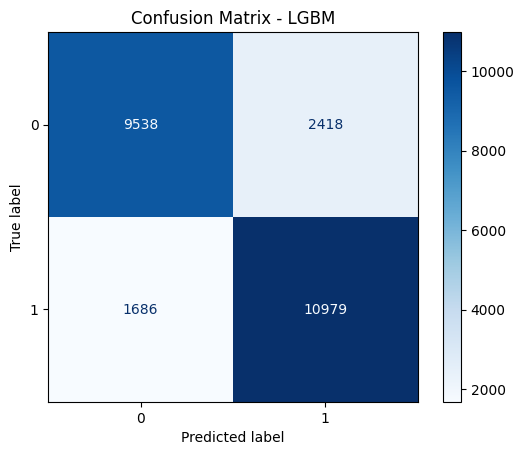

Classification Report - LGBM
              precision    recall  f1-score       support
0.0            0.849786  0.797758  0.822951  11956.000000
1.0            0.819512  0.866877  0.842529  12665.000000
accuracy       0.833313  0.833313  0.833313      0.833313
macro avg      0.834649  0.832318  0.832740  24621.000000
weighted avg   0.834213  0.833313  0.833022  24621.000000

Confusion Matrix - SVM
[[ 2909  9047]
 [  713 11952]]


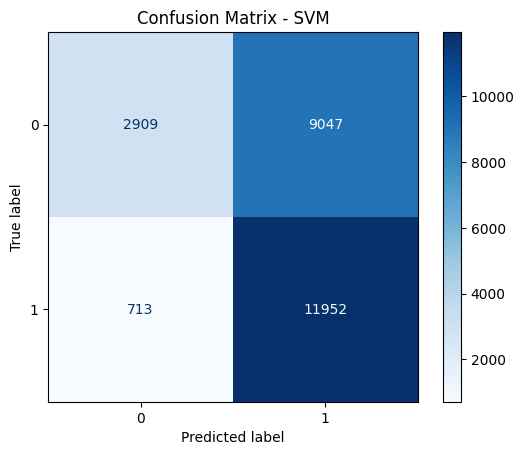

Classification Report - SVM
              precision    recall  f1-score      support
0.0            0.803147  0.243309  0.373475  11956.00000
1.0            0.569170  0.943703  0.710076  12665.00000
accuracy       0.603590  0.603590  0.603590      0.60359
macro avg      0.686159  0.593506  0.541776  24621.00000
weighted avg   0.682790  0.603590  0.546622  24621.00000

Confusion Matrix - MLP
[[ 5525  6431]
 [  747 11918]]


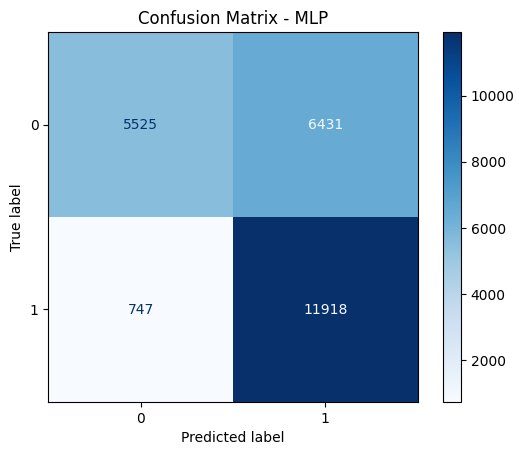

Classification Report - MLP
              precision    recall  f1-score      support
0.0            0.880899  0.462111  0.606210  11956.00000
1.0            0.649518  0.941019  0.768556  12665.00000
accuracy       0.708460  0.708460  0.708460      0.70846
macro avg      0.765208  0.701565  0.687383  24621.00000
weighted avg   0.761877  0.708460  0.689721  24621.00000


In [ ]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, recall_score, precision_score, roc_auc_score,
    confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE

def mark_pre_npf_signal(df, flag_column='flag3', window=144):
    signal = np.zeros(len(df))
    for i in range(1, len(df)):
        if df[flag_column].iat[i] == 1 and df[flag_column].iat[i-1] == 0:
            start = max(0, i - window)
            signal[start:i] = 1
    return pd.Series(signal, index=df.index, name='npf_signal')

df = pd.read_csv('aligned_data_2018_2023_all_11202024.csv')
df['npf_signal'] = mark_pre_npf_signal(df, window=144)

features = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]
X = df[features].fillna(df[features].mean())
y = df['npf_signal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_tr, y_tr = SMOTE(random_state=42).fit_resample(X_train, y_train)


from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

models = {
    'RF': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGB': XGBClassifier(max_depth=6, learning_rate=0.1, n_estimators=100,
                         eval_metric='logloss', use_label_encoder=False, random_state=42),
    'LGBM': LGBMClassifier(max_depth=6, learning_rate=0.1, n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, C=1.0, gamma='scale', max_iter=1000, random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, random_state=42)
}

results = []
all_predictions = {}

for name, model in models.items():
    print(f"Training {name}...")

    t0 = time.time()
    model.fit(X_tr, y_tr)
    train_time = time.time() - t0

    t1 = time.time()
    preds = model.predict(X_test)
    infer_time = time.time() - t1

    probs = model.predict_proba(X_test)[:, 1]
    cm = confusion_matrix(y_test, preds)
    cr = classification_report(y_test, preds, digits=4, output_dict=True)

    all_predictions[name] = {
        'model': model,
        'preds': preds,
        'probs': probs,
        'conf_matrix': cm,
        'class_report': cr
    }

    results.append({
        'Model': name,
        'F1': f1_score(y_test, preds),
        'Recall': recall_score(y_test, preds),
        'Precision': precision_score(y_test, preds),
        'AUC': roc_auc_score(y_test, probs),
        'TrainTime': train_time,
        'InferTime': infer_time,
        'Hyperparams': len(model.get_params()),
        'HasFeatureImp': hasattr(model, 'feature_importances_')
    })

df_res = pd.DataFrame(results)

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for model_name, items in all_predictions.items():
    cm = items['conf_matrix']
    print(f"\nConfusion Matrix - {model_name}")
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    print(f"Classification Report - {model_name}")
    print(pd.DataFrame(items['class_report']).T)

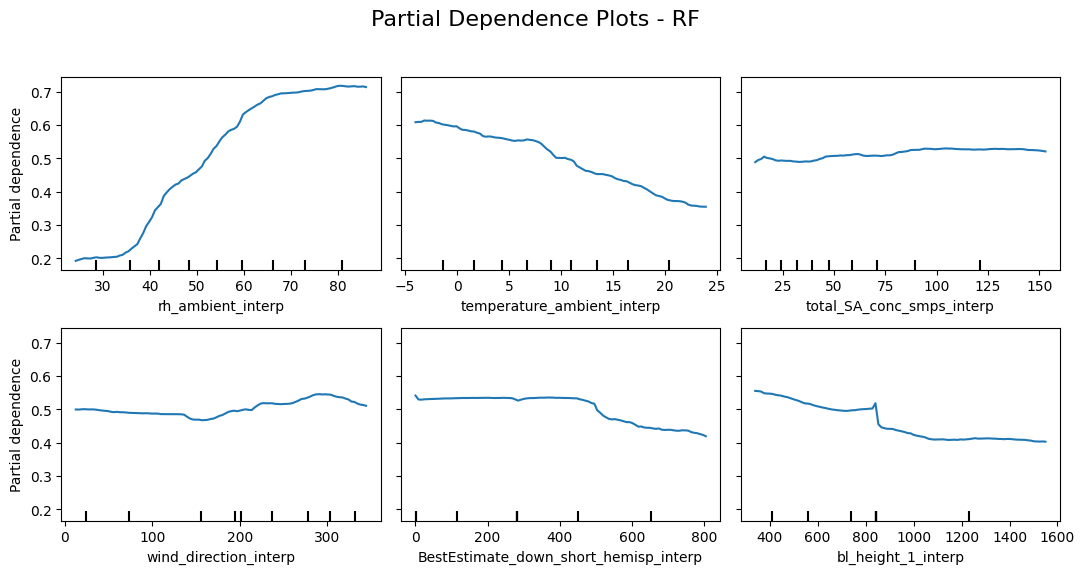

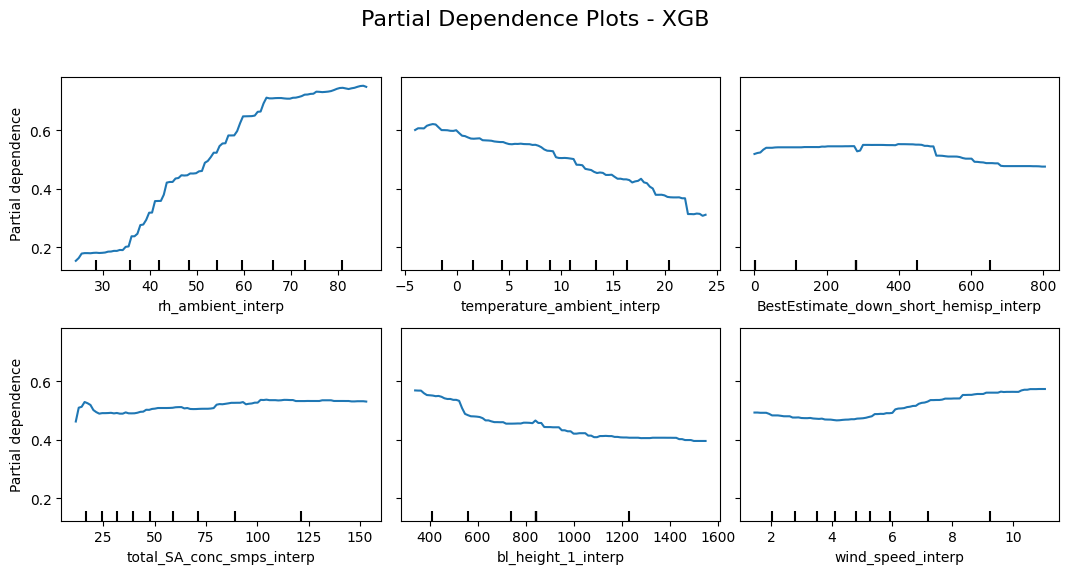

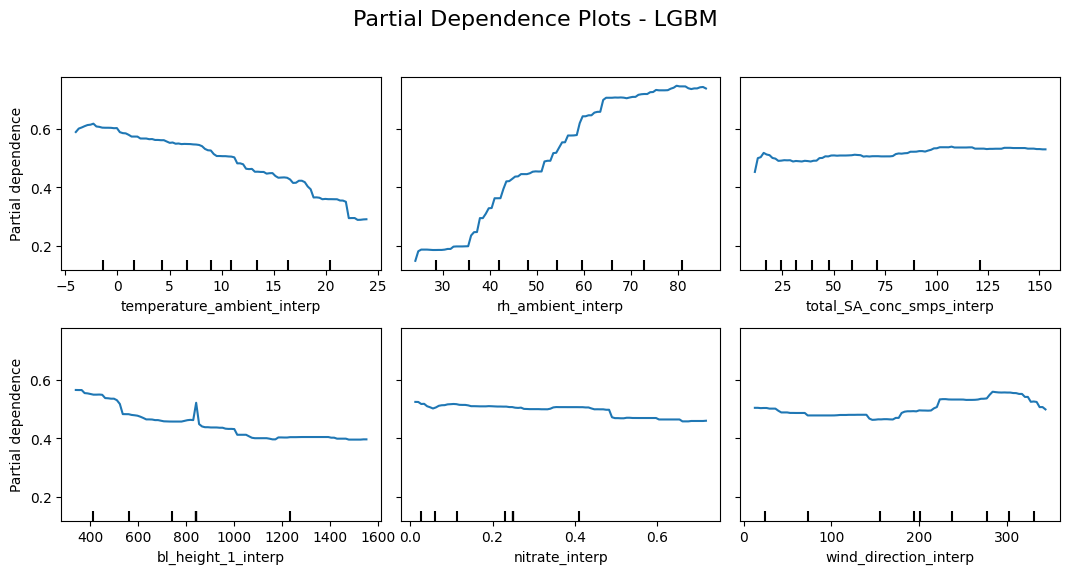

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

features_columns = [
    'bl_height_1_interp', 'total_organics_interp', 'sulfate_interp',
    'nitrate_interp', 'rh_ambient_interp', 'temperature_ambient_interp',
    'wind_direction_interp', 'wind_speed_interp', 'total_SA_conc_smps_interp',
    'so2_interp', 'turbulent_kinetic_energy_interp', 'BestEstimate_down_short_hemisp_interp'
]

def get_top6_features(model, feature_names):
    importances = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    return importance_df['Feature'].head(6).tolist()

for model_name in ['RF', 'XGB', 'LGBM']:
    model = all_predictions[model_name]['model']
    top6_features = get_top6_features(model, features_columns)

    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10.8, 6))
    PartialDependenceDisplay.from_estimator(
        model, X_train, features=top6_features, ax=ax
    )
    plt.suptitle(f"Partial Dependence Plots - {model_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

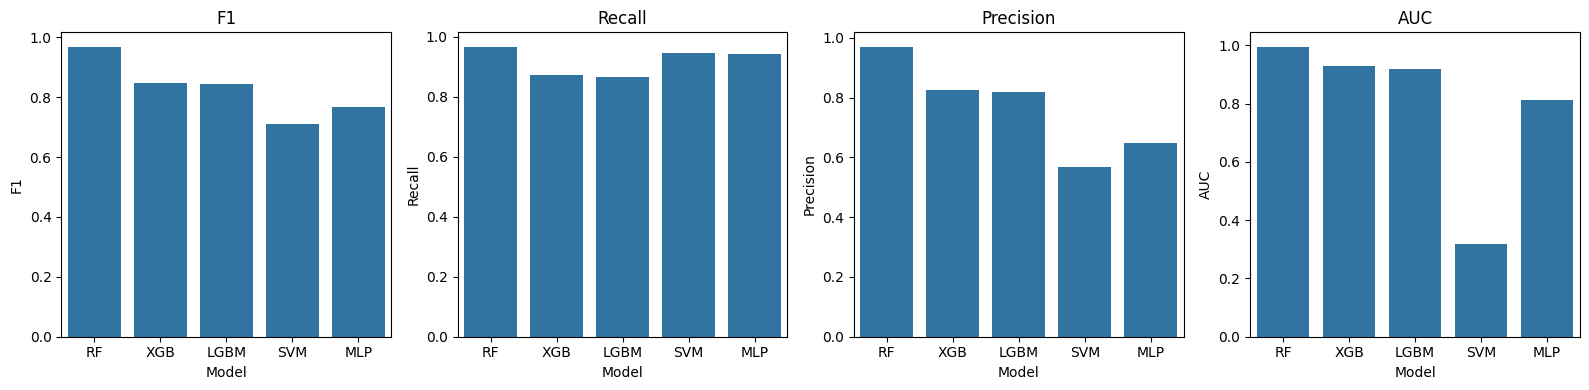

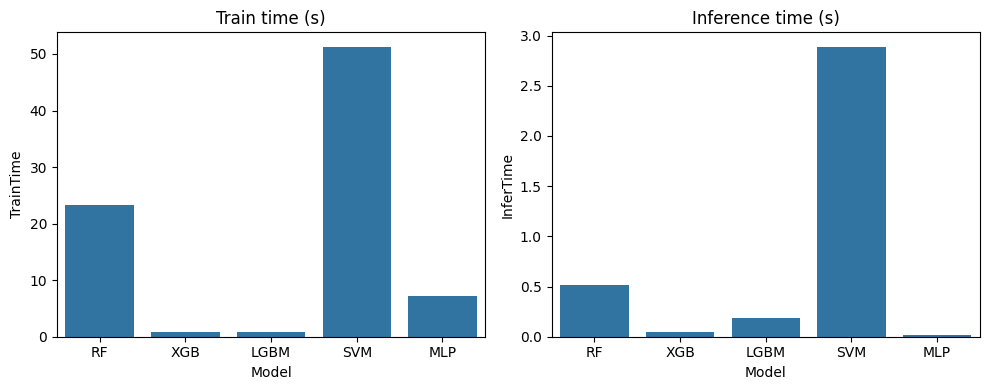

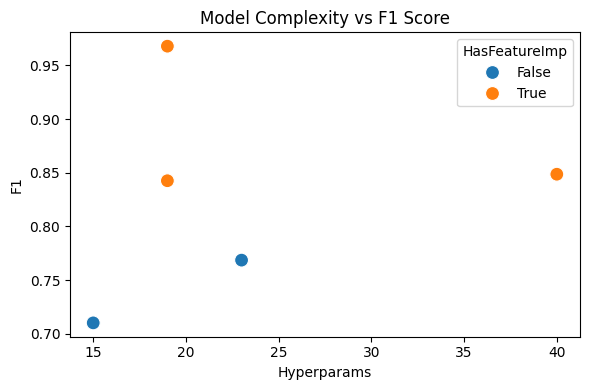

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bar plot for performance metrics
metrics = ['F1','Recall','Precision','AUC']
fig, axes = plt.subplots(1, len(metrics), figsize=(16,4))
for ax, m in zip(axes, metrics):
    sns.barplot(data=df_res, x='Model', y=m, ax=ax)
    ax.set_title(m)
plt.tight_layout()
plt.show()

# Training & inference time
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.barplot(data=df_res, x='Model', y='TrainTime', ax=ax[0]).set_title('Train time (s)')
sns.barplot(data=df_res, x='Model', y='InferTime', ax=ax[1]).set_title('Inference time (s)')
plt.tight_layout()
plt.show()

# Hyperparameter count vs interpretability
fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(data=df_res, x='Hyperparams', y='F1', hue='HasFeatureImp', s=100, ax=ax)
ax.set_title('Model Complexity vs F1 Score')
plt.tight_layout()
plt.show()